## Statistical analyses of reciprocal transplant simulations

by Bin Wang (@bioatmo_sphere or wbwenwu@gmail.com)

UC Irvine & ORNL

10/04/2021

---
Companion of **gradient_analysis_v1.ipynb**.

Structured as follows:

- **Environment and R packages**

- **Gradient analysis**

- **Transplant analysis**
- - Partitioning variance of substrates/decompostion
- - Partitioning variance of traits
- - Regression of decomposition against traits and envs

- **Validation of model with data before transplant**

### 0. Computing environment and packages

In [1]:
library(car)
#library(nlme)
library(lme4)
#library(ggplot2)
print(sessionInfo())

Loading required package: carData

Loading required package: Matrix

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 



R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] lme4_1.1-27   Matrix_1.3-3  car_3.0-10    carData_3.0-4

loaded via a namespace (and not attached):
 [1] zip_2.2.0         Rcpp_1.0.6        nloptr_1.2.2.2    pillar_1.6.1     
 [5] compiler_4.1.0    cellranger_1.1.0  forcats_0.5.1     base64enc_0.1-3  
 [9] tools_4.1.0       boot_1.3-28       digest_0.6.27     uuid_0.1-4       
[13] nlme_3.1-152      lattice_0.20-44   jsonlite_1.7.2    evaluate_0.14    
[17] lifecycle_1.0.0   tibble_3.1.2      pkgconfig_2.0.3   rlang_0.4.11     
[21] openxls

### 1. Analysis of variance (one-way) of decomposition and traits prior to transplanting

Data of each of the five sites across the gradient (i.e.,before transplanting).

In [2]:
#define a function of obtaining data of any day
data_origin <- function(sub_data,day){
    
    sub_data_fr <- do.call("cbind.data.frame", sub_data)
    data_decom <- t(sub_data_fr[as.character(day),])
    colnames(data_decom) = 'decom'
    
    site=c('desert','scrubland','grassland','pineoak','subalpine')
    data_origin = cbind(data.frame(origin=rep(site,times=1, each=1*20),site=rep(site,times=1,each=20)),
                       data_decom)
    
    data_origin
}

In [3]:
#create file list and read the drought tolerance data into a list
file_list <- list()
for (i in 1:5){
    site=c('desert','scrubland','grassland','pineoak','subalpine')
    name<-data.frame(origin=rep(site,times=1,each=1),site=rep(site,times=1,each=1))

    file_list[i] = paste(name$origin[i],"/","Drt_",name$origin[i],"_",name$site[i],'.csv',sep="")
}
drt_data <- lapply(file_list,function(path)read.csv(path,row.names=1))

In [51]:
drt_anova_d1 <- data_origin(drt_data,1+365*4)
head(drt_anova_d1)

,origin,site,decom
,<chr>,<chr>,<dbl>
X0,desert,desert,0.4186110
X1,desert,desert,0.4956844
X2,desert,desert,0.5940668
X3,desert,desert,0.5199044
X4,desert,desert,0.3664284
X5,desert,desert,0.4817593


In [52]:
str(drt_anova_d1)

'data.frame':	100 obs. of  3 variables:
 $ origin: chr  "desert" "desert" "desert" "desert" ...
 $ site  : chr  "desert" "desert" "desert" "desert" ...
 $ decom : num  0.419 0.496 0.594 0.52 0.366 ...


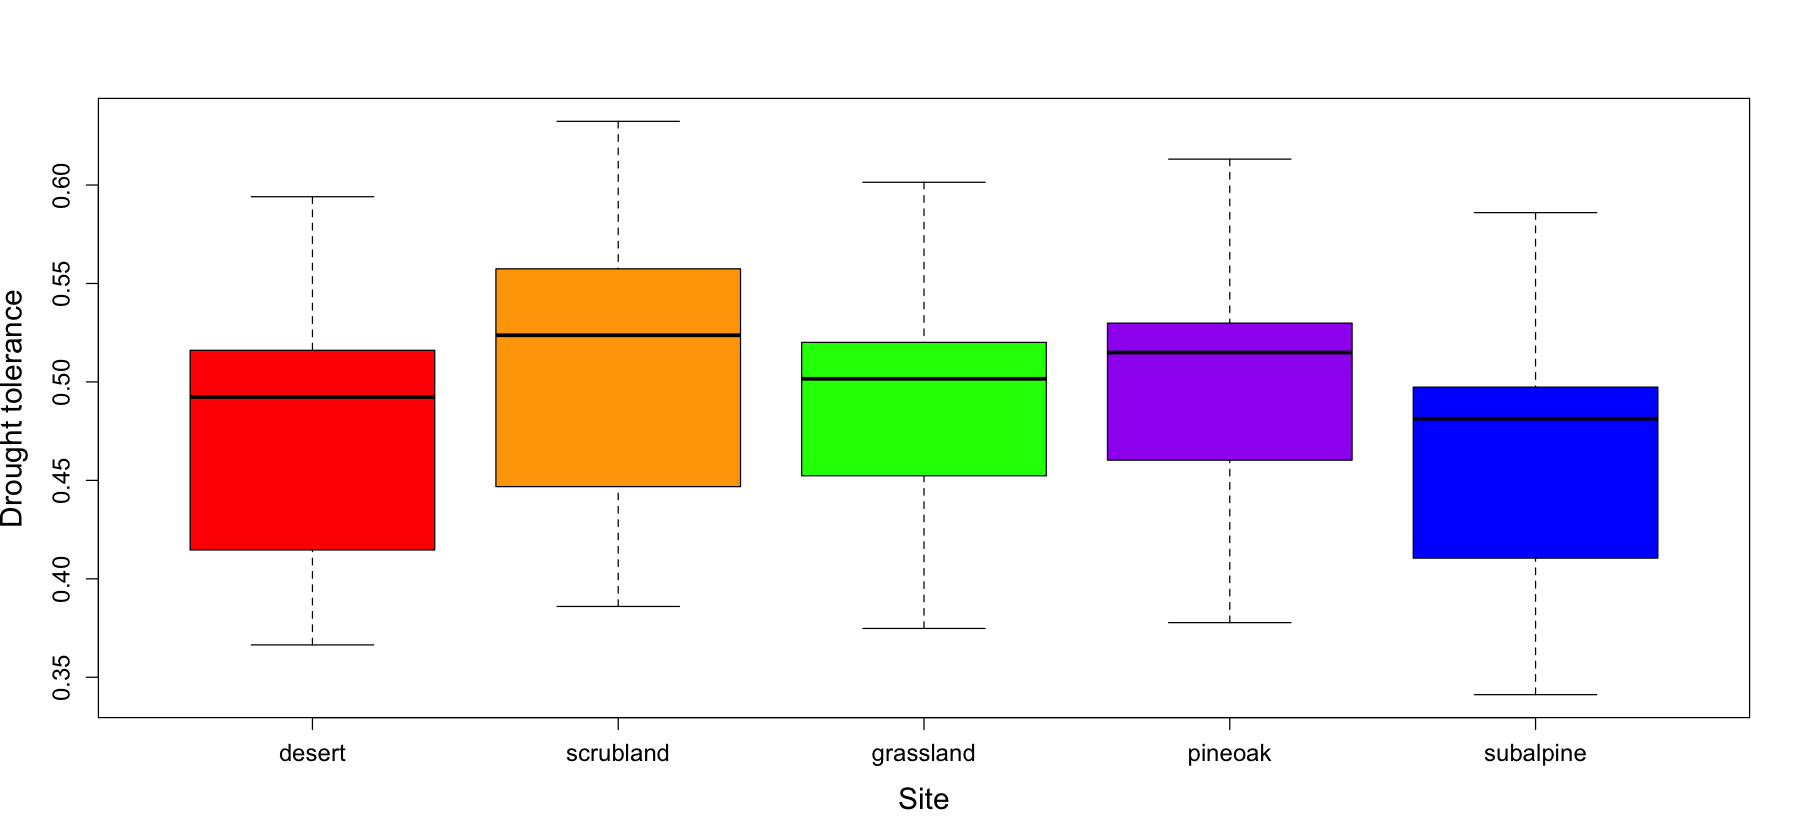

In [53]:
drt_anova_d1$origin <- factor(drt_anova_d1$origin, levels=c("desert",'scrubland','grassland','pineoak','subalpine'))
boxplot(drt_anova_d1$decom ~ drt_anova_d1$origin,
       xlab = "Site",ylab = 'Drought tolerance',
       col=c("red","orange","green","purple",'blue'),
       cex.lab=1.5,cex.axis=1.2)

In [54]:
fit <- aov(decom ~ origin, data=drt_anova_d1)
summary(fit)

            Df  Sum Sq  Mean Sq F value Pr(>F)  
origin       4 0.02916 0.007291   2.207  0.074 .
Residuals   95 0.31386 0.003304                 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [37]:
TukeyHSD(fit,'origin',ordered=TRUE)

  Tukey multiple comparisons of means
    95% family-wise confidence level
    factor levels have been ordered

Fit: aov(formula = decom ~ origin, data = drt_anova_d1)

$origin
                          diff          lwr       upr     p adj
pineoak-subalpine   0.05639540 -0.003603114 0.1163939 0.0758676
grassland-subalpine 0.16217766  0.102179147 0.2221762 0.0000000
scrubland-subalpine 0.31407152  0.254073013 0.3740700 0.0000000
desert-subalpine    0.40793917  0.347940661 0.4679377 0.0000000
grassland-pineoak   0.10578226  0.045783752 0.1657808 0.0000378
scrubland-pineoak   0.25767613  0.197677618 0.3176746 0.0000000
desert-pineoak      0.35154378  0.291545266 0.4115423 0.0000000
scrubland-grassland 0.15189387  0.091895357 0.2118924 0.0000000
desert-grassland    0.24576151  0.185763005 0.3057600 0.0000000
desert-scrubland    0.09386765  0.033869139 0.1538662 0.0003242


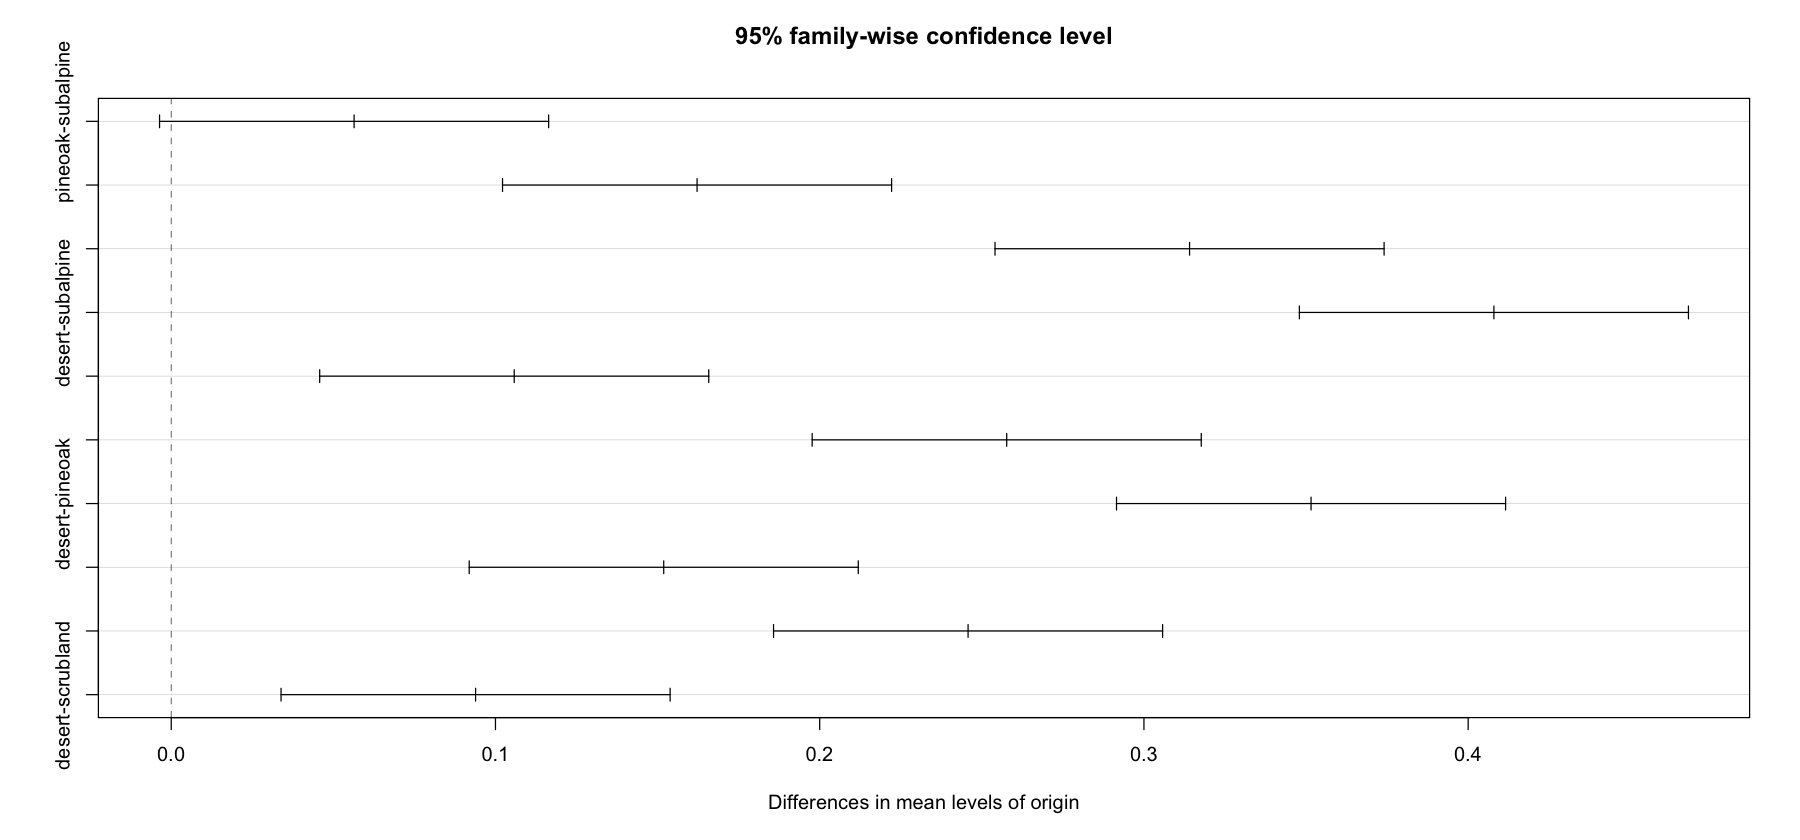

In [38]:
plot(TukeyHSD(fit,'origin',ordered=TRUE))

In [39]:
#create file list and read the enzyme trait data into a list
file_list <- list()
for (i in 1:5){
    site=c('desert','scrubland','grassland','pineoak','subalpine')
    name<-data.frame(origin=rep(site,times=1,each=1),site=rep(site,times=1,each=1))

    file_list[i] = paste(name$origin[i],"/","Enz_",name$origin[i],"_",name$site[i],'.csv',sep="")
}
enz_data <- lapply(file_list,function(path)read.csv(path,row.names=1))

In [43]:
enz_anova_d1 <- data_origin(enz_data,0+365*4)
head(enz_anova_d1)

,origin,site,decom
,<chr>,<chr>,<dbl>
X0,desert,desert,0.002201265
X1,desert,desert,0.001698342
X2,desert,desert,0.001785880
X3,desert,desert,0.001034520
X4,desert,desert,0.001219593
X5,desert,desert,0.002071712


In [44]:
str(enz_anova_d1)

'data.frame':	100 obs. of  3 variables:
 $ origin: chr  "desert" "desert" "desert" "desert" ...
 $ site  : chr  "desert" "desert" "desert" "desert" ...
 $ decom : num  0.0022 0.0017 0.00179 0.00103 0.00122 ...


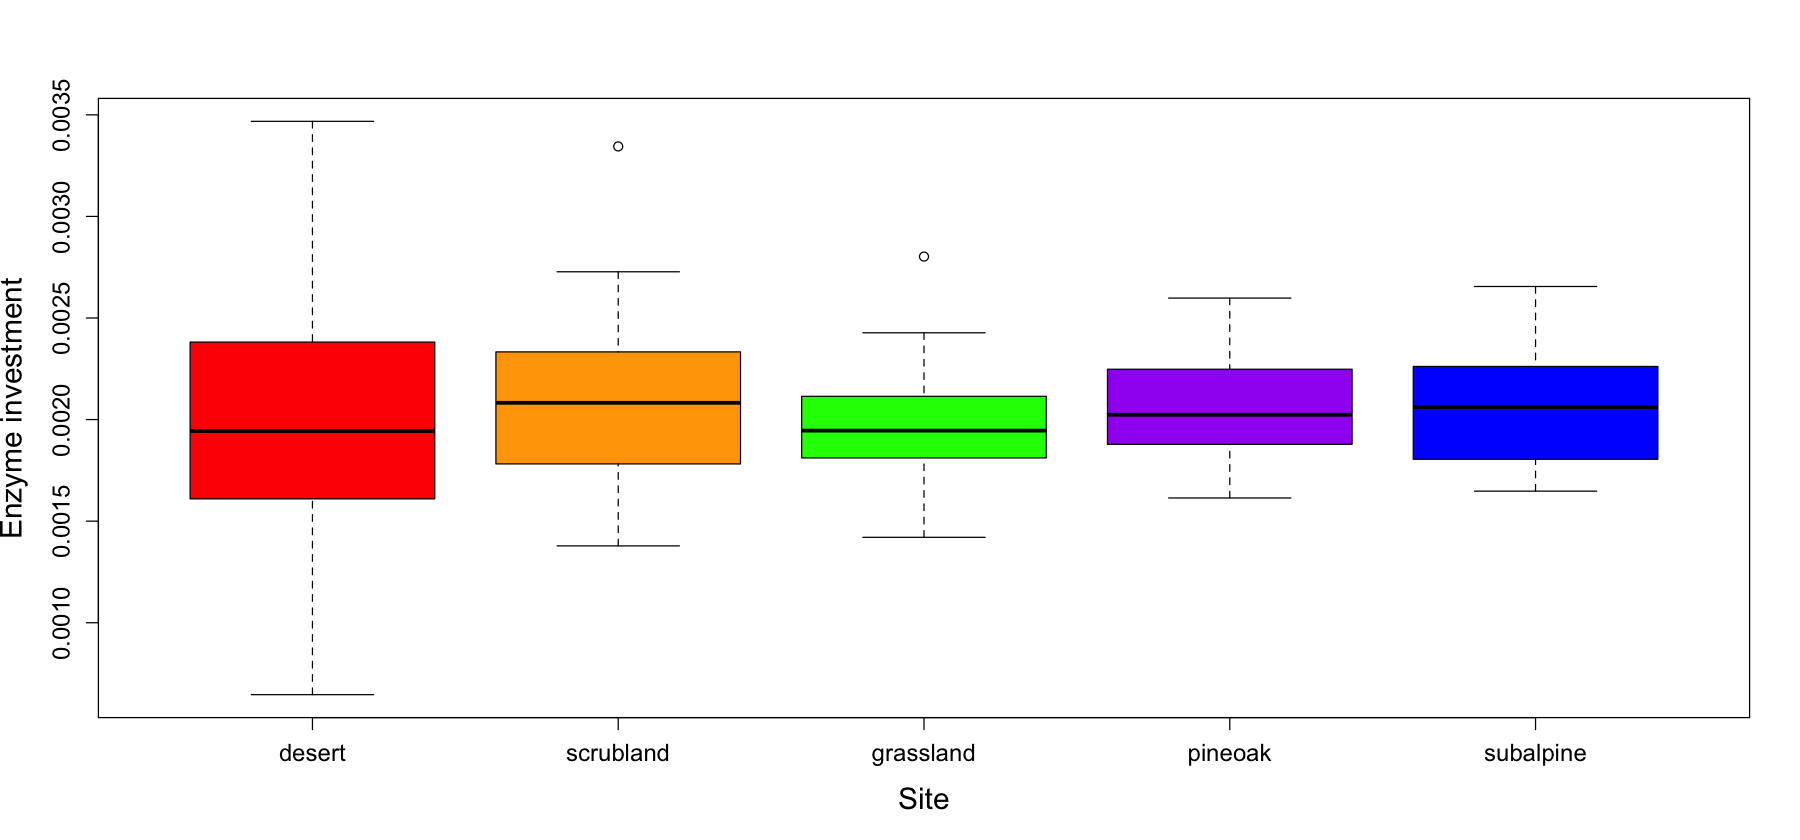

In [45]:
enz_anova_d1$origin <- factor(enz_anova_d1$origin, levels=c("desert",'scrubland','grassland','pineoak','subalpine'))

boxplot(enz_anova_d1$decom ~ enz_anova_d1$origin,
       xlab = "Site",ylab = 'Enzyme investment',
       col=c("red","orange","green","purple",'blue'),
       cex.lab=1.5,cex.axis=1.2)

In [46]:
fit <- aov(decom ~ origin, data=enz_anova_d1)
summary(fit)

            Df    Sum Sq   Mean Sq F value Pr(>F)
origin       4 2.540e-07 6.344e-08   0.359  0.837
Residuals   95 1.679e-05 1.767e-07               

In [47]:
TukeyHSD(fit,'origin',ordered=TRUE,conf.level = 0.90)

  Tukey multiple comparisons of means
    90% family-wise confidence level
    factor levels have been ordered

Fit: aov(formula = decom ~ origin, data = enz_anova_d1)

$origin
                            diff           lwr          upr     p adj
grassland-desert    2.008577e-06 -0.0003298983 0.0003339155 1.0000000
pineoak-desert      8.423116e-05 -0.0002476758 0.0004161381 0.9692255
subalpine-desert    8.956520e-05 -0.0002423417 0.0004214721 0.9616125
scrubland-desert    1.253040e-04 -0.0002066029 0.0004572109 0.8794878
pineoak-grassland   8.222259e-05 -0.0002496843 0.0004141295 0.9718081
subalpine-grassland 8.755663e-05 -0.0002443503 0.0004194635 0.9646103
scrubland-grassland 1.232954e-04 -0.0002086115 0.0004552023 0.8855861
subalpine-pineoak   5.334040e-06 -0.0003265729 0.0003372410 0.9999994
scrubland-pineoak   4.107284e-05 -0.0002908341 0.0003729798 0.9979874
scrubland-subalpine 3.573880e-05 -0.0002961681 0.0003676457 0.9988333


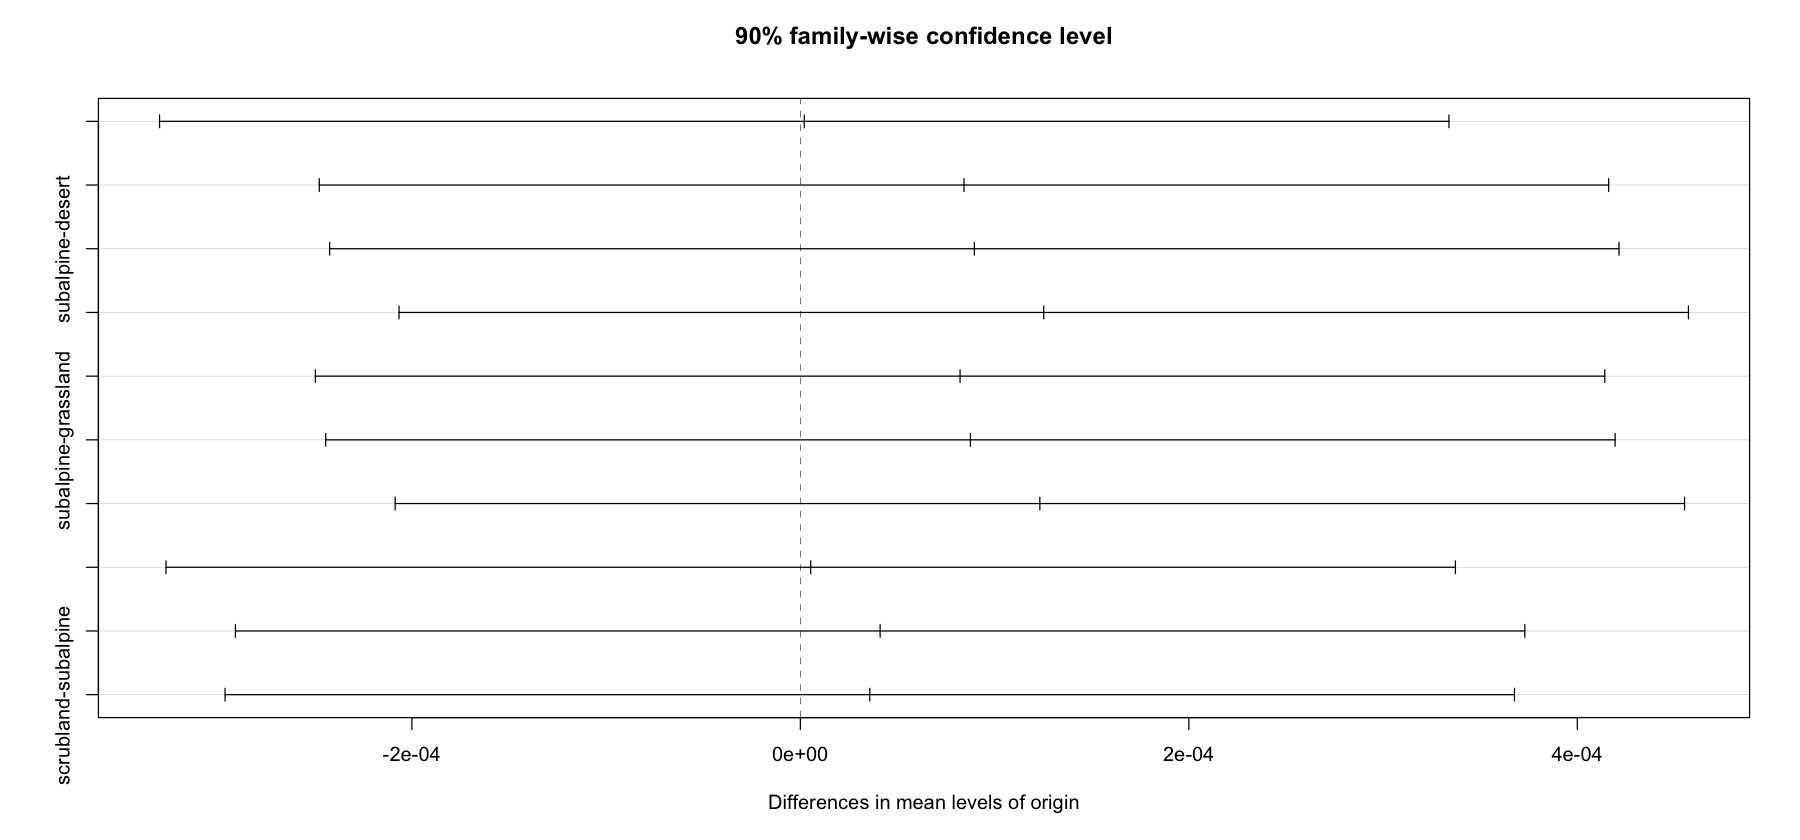

In [48]:
plot(TukeyHSD(fit,'origin',ordered=TRUE,conf.level = 0.90))

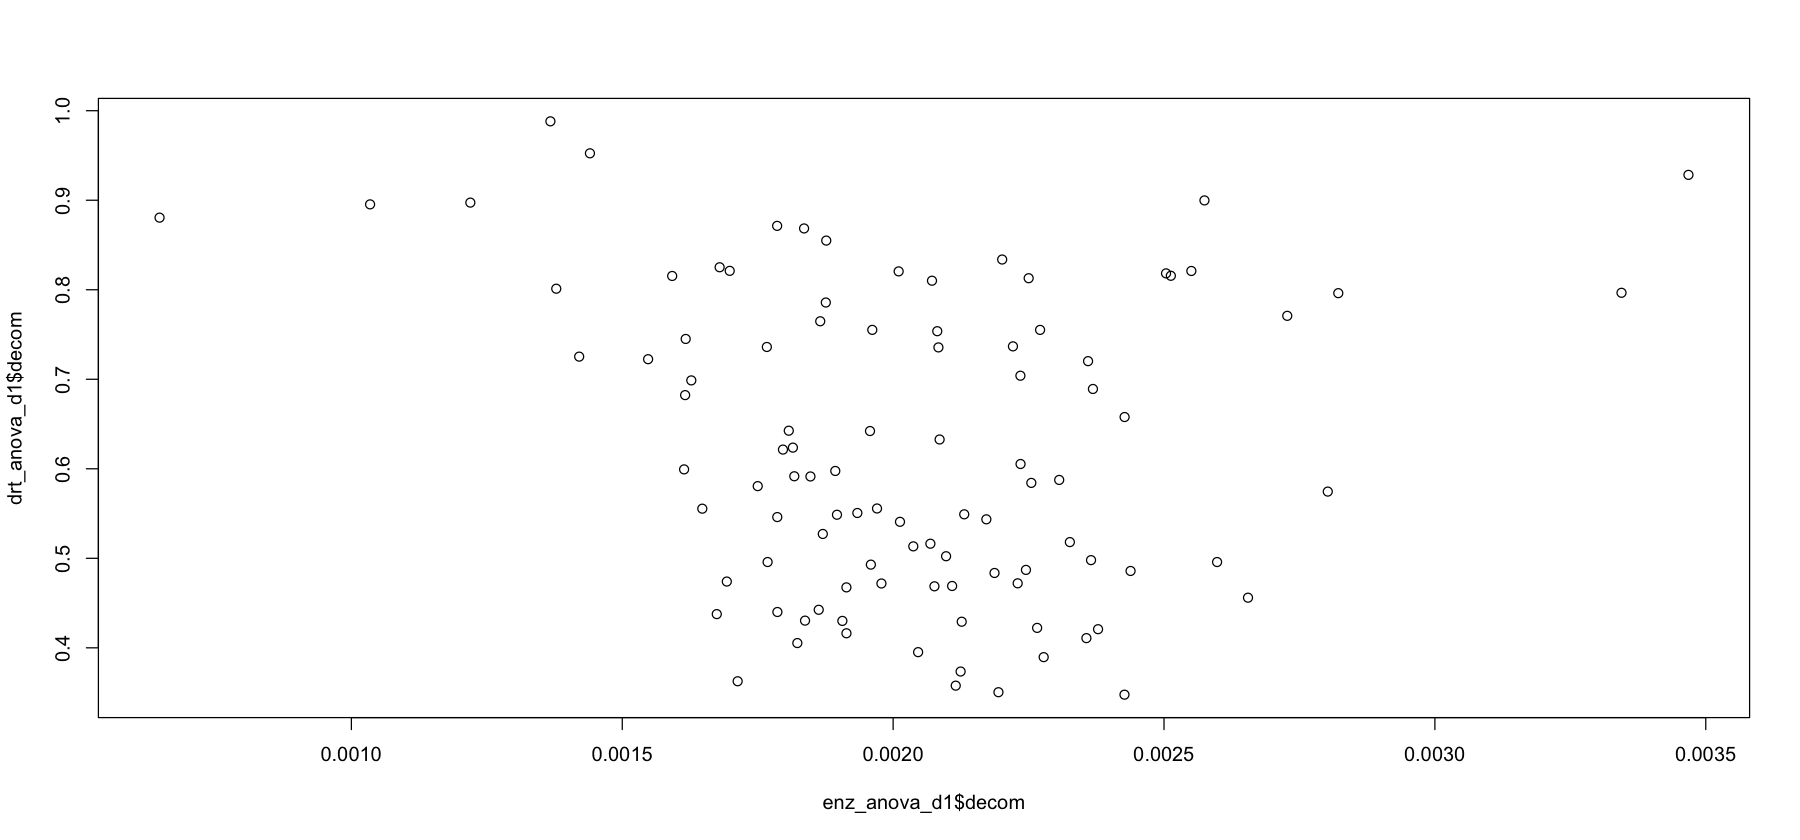

In [49]:
plot(enz_anova_d1$decom,drt_anova_d1$decom)

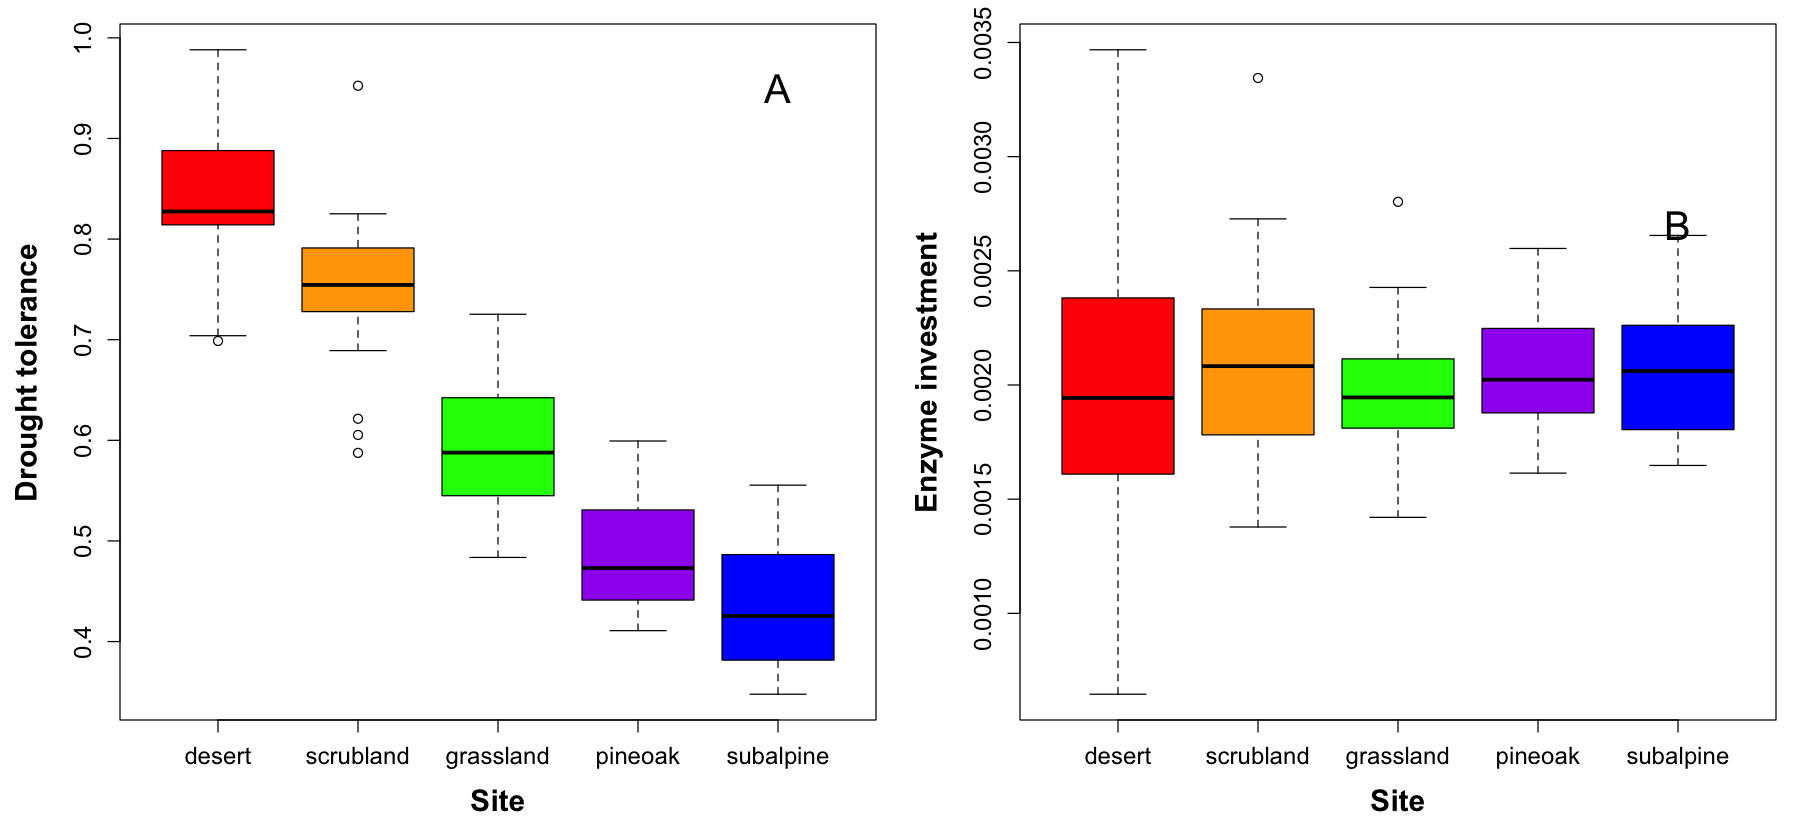

In [50]:
##########################################
##### combine the two box plots ##########
##########################################

options(repr.plot.width=15,repr.plot.height=7)

#pdf("figures/community.pdf",width=15,height=7)

par(mfrow=c(1,2),mar=c(5,5,1,1))

boxplot(drt_anova_d1$decom ~ drt_anova_d1$origin,
       xlab = expression(bold("Site")),ylab = expression(bold('Drought tolerance')),
       col=c("red","orange","green","purple",'blue'),
       cex.lab=1.5,cex.axis=1.2,font=2)
text(x=5,y=0.95,"A",col="black",font=1,cex=2.0)

boxplot(enz_anova_d1$decom ~ enz_anova_d1$origin,
       xlab = expression(bold("Site")),ylab = expression(bold('Enzyme investment')),
       col=c("red","orange","green","purple",'blue'),
       cex.lab=1.5,cex.axis=1.2,font=2)

text(x=5,y=0.0027,"B",col="black",font=1,cex=2.0)

#dev.off()

In [19]:
#create file list and read the substrates data into a list
file_list <- list()
for (i in 1:5){
    site=c('desert','scrubland','grassland','pineoak','subalpine')
    name<-data.frame(origin=rep(site,times=1,each=1),site=rep(site,times=1,each=1))

    file_list[i] = paste(name$origin[i],"/","Sub_",name$origin[i],"_",name$site[i],'.csv',sep="")
}
sub_data <- lapply(file_list,function(path)read.csv(path,row.names=1))

In [20]:
sub_anova_d1 <- data_origin(sub_data,1+365*4 - 1)
head(sub_anova_d1)

,origin,site,decom
,<chr>,<chr>,<dbl>
X0,desert,desert,1107270.6
X1,desert,desert,425206.7
X2,desert,desert,1380426.4
X3,desert,desert,593682.2
X4,desert,desert,1242333.2
X5,desert,desert,1488887.4


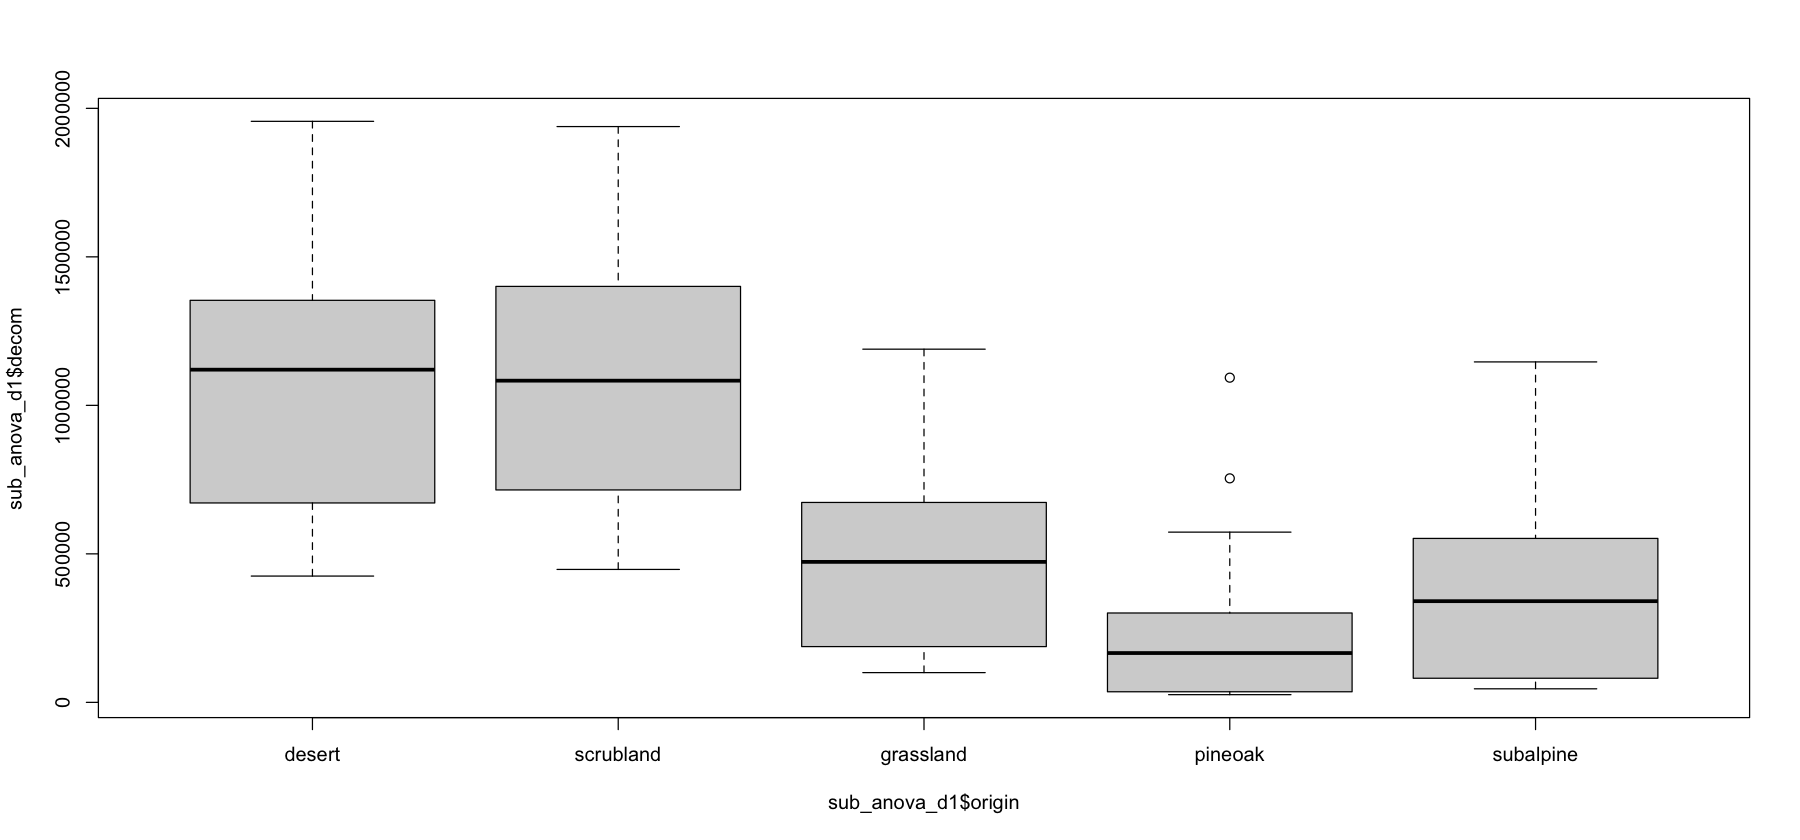

In [22]:
#new_order <- with(sub_anova_d1,reorder())

sub_anova_d1$origin <- factor(sub_anova_d1$origin, levels=c("desert",'scrubland','grassland','pineoak','subalpine'))
boxplot(sub_anova_d1$decom ~ sub_anova_d1$origin)

In [23]:
fit <- aov(decom ~ origin, data=sub_anova_d1)
summary(fit)

            Df    Sum Sq   Mean Sq F value   Pr(>F)    
origin       4 1.252e+13 3.130e+12    24.7 4.97e-14 ***
Residuals   95 1.204e+13 1.267e+11                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [24]:
TukeyHSD(fit,'origin',ordered=TRUE,conf.level = 0.95)

  Tukey multiple comparisons of means
    95% family-wise confidence level
    factor levels have been ordered

Fit: aov(formula = decom ~ origin, data = sub_anova_d1)

$origin
                          diff        lwr       upr     p adj
subalpine-pineoak   157847.506 -155226.32  470921.3 0.6278615
grassland-pineoak   244828.699  -68245.13  557902.5 0.1982949
scrubland-pineoak   836858.715  523784.89 1149932.5 0.0000000
desert-pineoak      840107.236  527033.41 1153181.1 0.0000000
grassland-subalpine  86981.193 -226092.63  400055.0 0.9378754
scrubland-subalpine 679011.209  365937.38  992085.0 0.0000003
desert-subalpine    682259.730  369185.90  995333.6 0.0000003
scrubland-grassland 592030.016  278956.19  905103.8 0.0000088
desert-grassland    595278.537  282204.71  908352.4 0.0000078
desert-scrubland      3248.521 -309825.31  316322.3 0.9999998


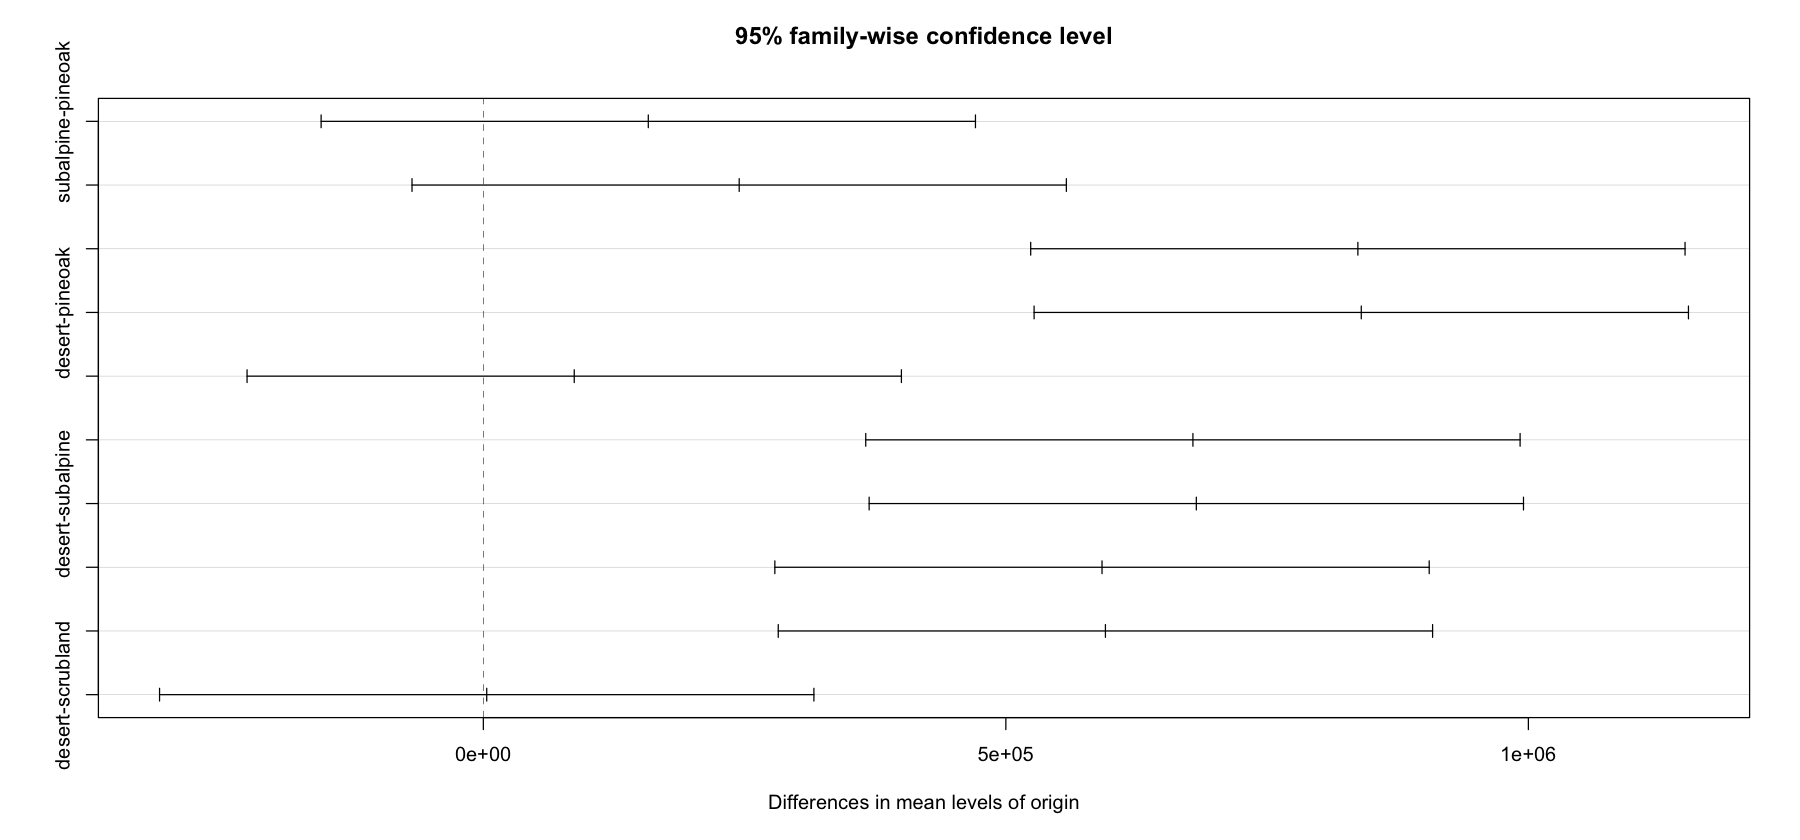

In [25]:
plot(TukeyHSD(fit,'origin',ordered=TRUE,conf.level = 0.95))

### 2. Analysis of transplant data

These data cover 4 x 365 days of decomposition and traits structured by a 5x5 (n=20) factorial design

#### 2.1. Analysis of variance of litter decomposition

ANOVA with a linear model at different time points were performed.

Ensure assumptions met!

- Homogeneity of Variance: https://www.datanovia.com/en/lessons/homogeneity-of-variance-test-in-r/
- Transforming data: https://rcompanion.org/handbook/I_12.html

References: 
- https://www.statmethods.net/stats/anova.html
- **mixed model analysis of variance**--theory: https://sk.sagepub.com/reference/sage-encyclopedia-of-educational-research-measurement-evaluation/i13711.xml; implementation: https://rpsychologist.com/r-guide-longitudinal-lme-lmer

**NOTE**: The experimentation starts from year 5 (on day 365*4+1)

In [26]:
#define a universal function of obtaining data of any day
data_anova <- function(sub_data,day){
    
    sub_data_fr <- do.call("cbind.data.frame", sub_data)
    data_decom <- t(sub_data_fr[as.character(day),])
    colnames(data_decom) = 'decom'
    
    site=c('desert','scrubland','grassland','pineoak','subalpine')
    data_anova = cbind(data.frame(origin=rep(site,times=1, each=5*20),site=rep(site,times=5,each=20)),
                       data_decom)
    
    data_anova
}

In [27]:
#create file list and read the source decomposition data into a list
file_list <- list()
for (i in 1:25){
    site=c('desert','scrubland','grassland','pineoak','subalpine')
    name<-data.frame(origin=rep(site,times=1,each=5),site=rep(site,times=5,each=1))

    file_list[i] = paste(name$origin[i],"/","Sub_",name$origin[i],"_",name$site[i],'.csv',sep="")
}
sub_data <- lapply(file_list,function(path)read.csv(path,row.names=1))

In [28]:
# obtain data of the "last" day of the 1st year transplant
data_anova_d1 <- data_anova(sub_data,1+365*4 + 365 - 1)
data_anova_d1[,'decom'] <- data_anova_d1$decom/10000
head(data_anova_d1)

,origin,site,decom
,<chr>,<chr>,<dbl>
X0,desert,desert,126.62488
X1,desert,desert,60.41394
X2,desert,desert,150.49190
X3,desert,desert,84.02024
X4,desert,desert,148.76512
X5,desert,desert,162.52719


In [29]:
fit_d1 <- aov(decom ~ origin + site + origin:site, data=data_anova_d1)
summary(fit_d1)

             Df Sum Sq Mean Sq F value Pr(>F)    
origin        4   6187    1547   1.059  0.376    
site          4 904234  226058 154.769 <2e-16 ***
origin:site  16   1663     104   0.071  1.000    
Residuals   475 693792    1461                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [30]:
cat('Contribution by each factor:',summary(fit_d1)[[1]]$'Sum Sq'/sum(summary(fit_d1)[[1]]$'Sum Sq'))

Contribution by each factor: 0.003852627 0.5630782 0.001035734 0.4320335

In [31]:
# obtain data of the "last" day of the "last(4th)"" year transplant
data_anova_d2 <- data_anova(sub_data,1+365*4 + 365*4 - 1)
data_anova_d2[,'decom'] <- data_anova_d2$decom/10000
head(data_anova_d2)

,origin,site,decom
,<chr>,<chr>,<dbl>
X0,desert,desert,NA
X1,desert,desert,NA
X2,desert,desert,NA
X3,desert,desert,NA
X4,desert,desert,NA
X5,desert,desert,NA


In [32]:
fit_d2 <- aov(decom ~ origin + site + origin:site, data=data_anova_d2)
summary(fit_d2)

ERROR: Error in `contrasts<-`(`*tmp*`, value = contr.funs[1 + isOF[nn]]): contrasts can be applied only to factors with 2 or more levels


In [11]:
cat('Contribution by each factor:',summary(fit_d2)[[1]]$'Sum Sq'/sum(summary(fit_d2)[[1]]$'Sum Sq'))

Contribution by each factor: 0.03842806 0.6858736 0.01465909 0.2610392

#### 2.2 Analysis of variance of Traits 

to dissentangle factors (history and local condiditions), and to what extent these factors, shape community traits.

In [12]:
###### enzyme investment
#create a file list and read the decomposition data into a list
file_list <- list()
for (i in 1:25){
    site=c('desert','scrubland','grassland','pineoak','subalpine')
    name<-data.frame(origin=rep(site,times=1,each=5),site=rep(site,times=5,each=1))

    file_list[i] = paste(name$origin[i],"/","Enz_",name$origin[i],"_",name$site[i],'.csv',sep="")
}
enz_data <- lapply(file_list,function(path)read.csv(path,row.names=1))

In [13]:
# Last day in the very 1st year
enz_data_d0 <- data_anova(enz_data,1+365*4 + 365 - 1)
head(enz_data_d0)

,origin,site,decom
,<chr>,<chr>,<dbl>
X0,desert,desert,0.0016435153
X1,desert,desert,0.0021950307
X2,desert,desert,0.0011091144
X3,desert,desert,0.0005713315
X4,desert,desert,0.0013090709
X5,desert,desert,0.0019363400


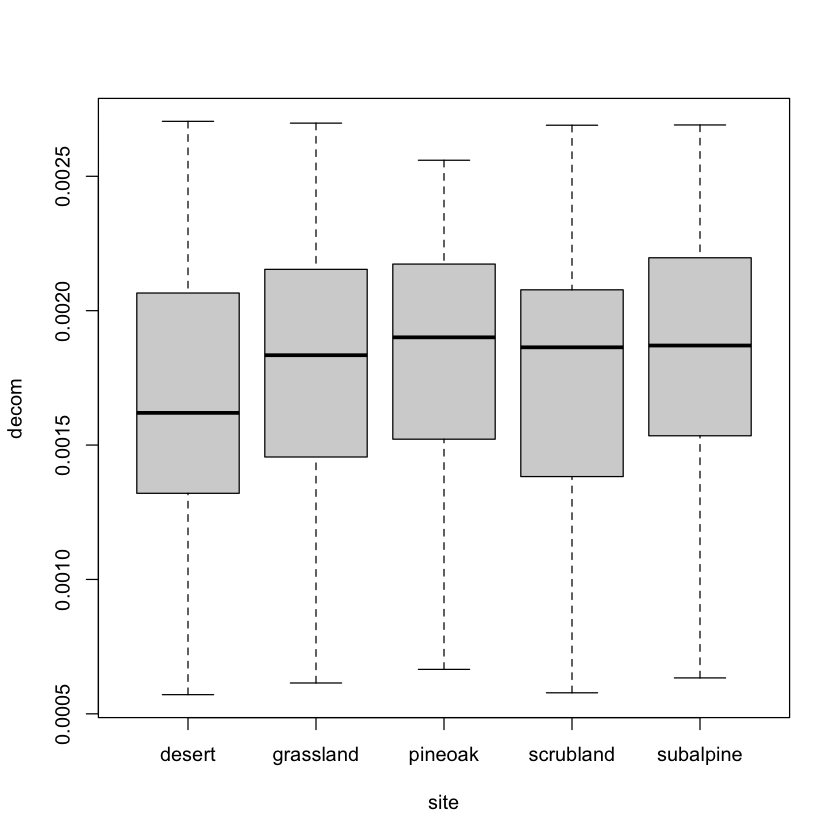

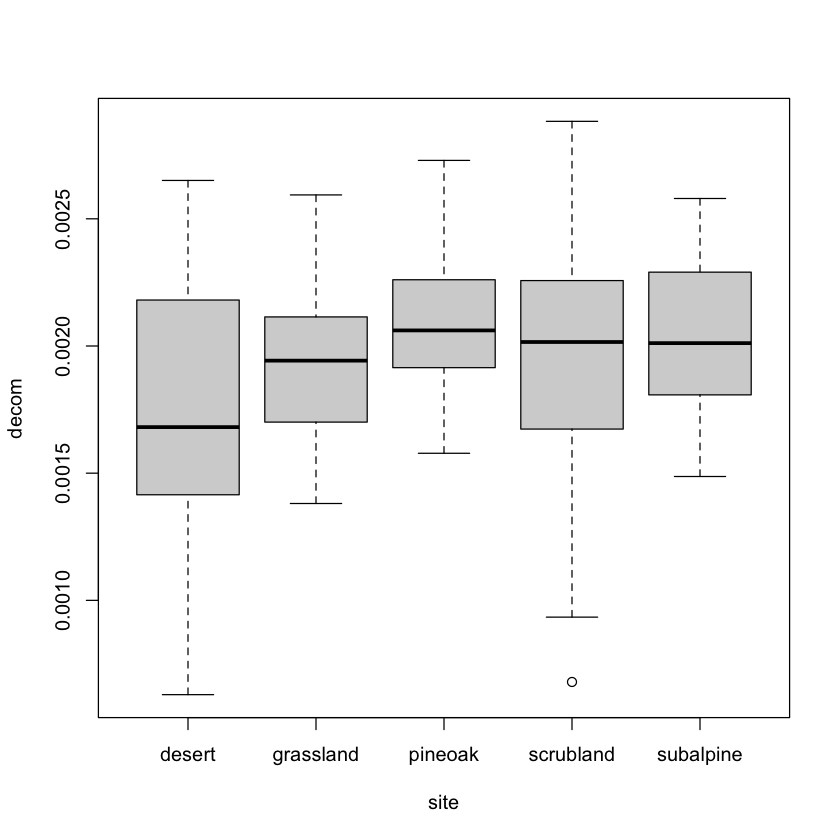

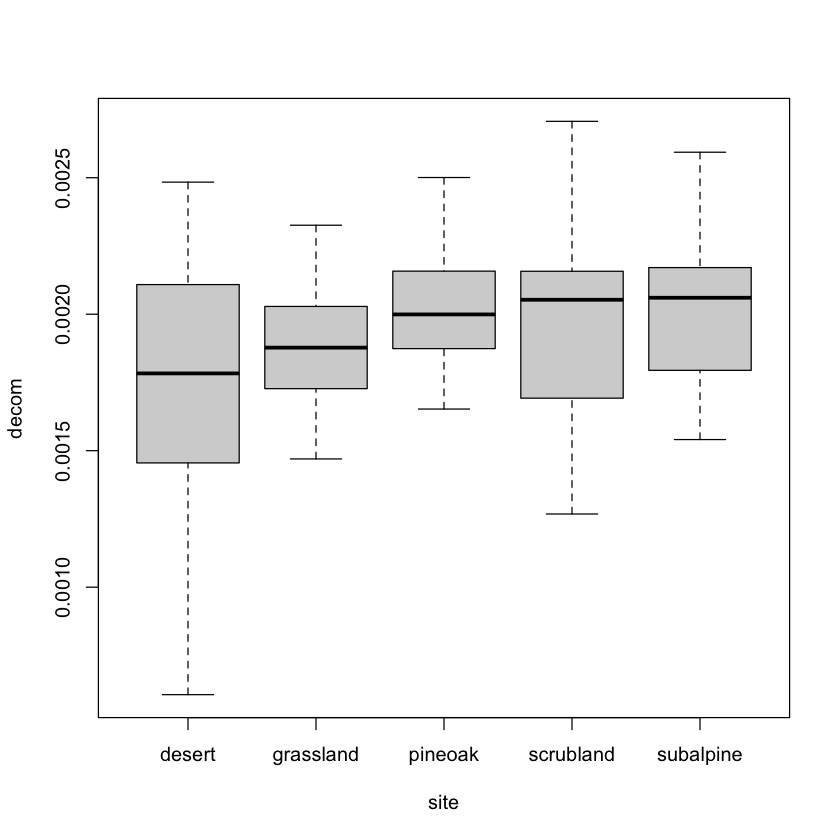

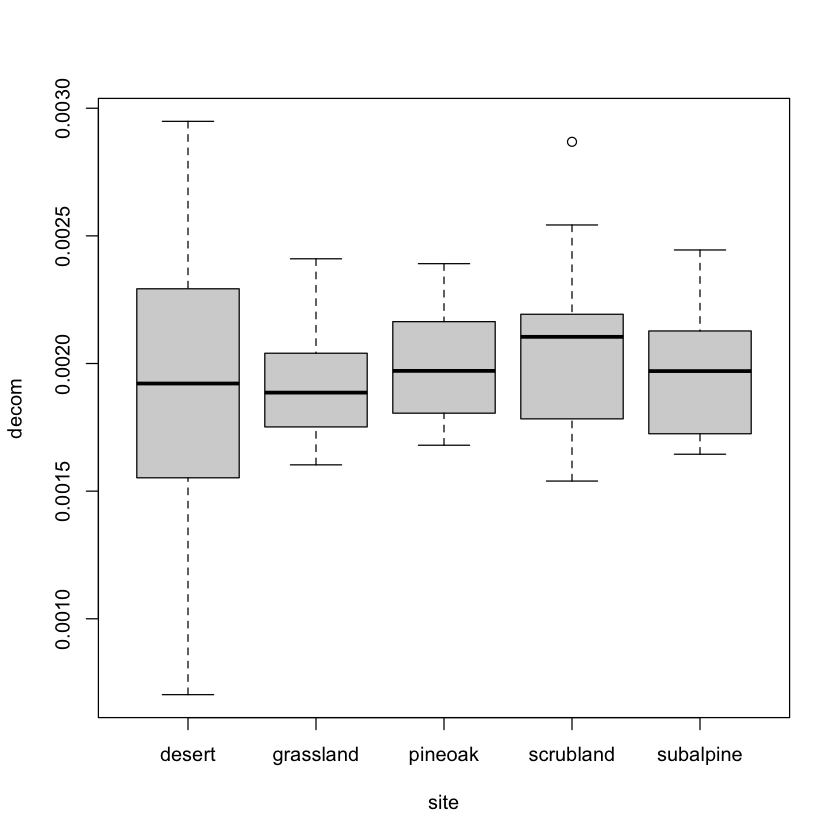

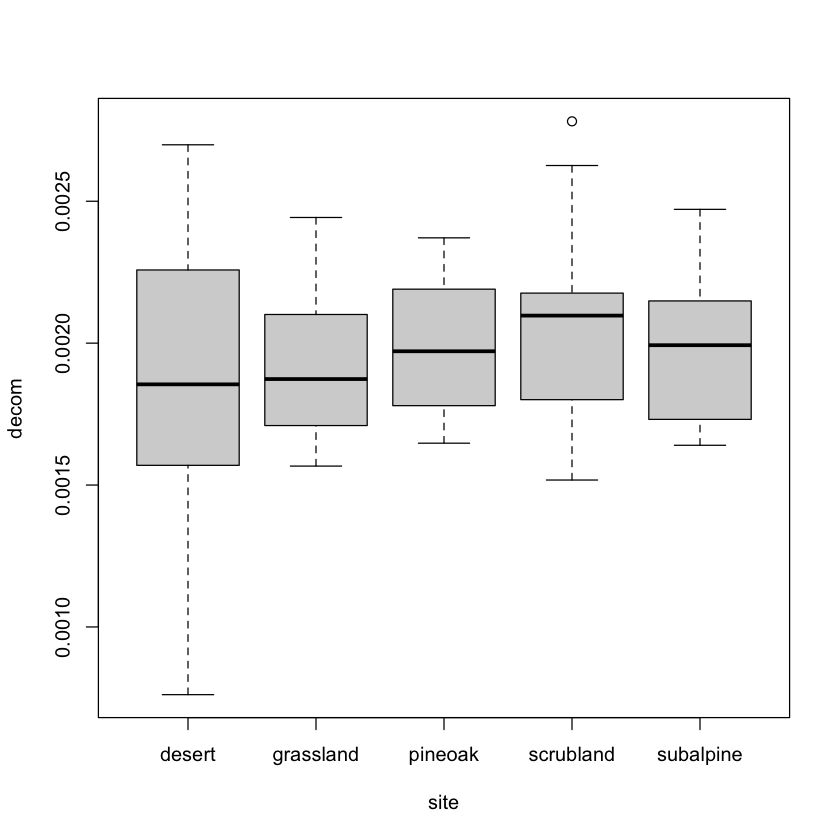

In [34]:
# homogeneity of variance
boxplot(decom ~ site,data=enz_data_d0[enz_data_d0['origin'] == 'desert',])
boxplot(decom ~ site,data=enz_data_d0[enz_data_d0['origin'] == 'scrubland',])
boxplot(decom ~ site,data=enz_data_d0[enz_data_d0['origin'] == 'grassland',])
boxplot(decom ~ site,data=enz_data_d0[enz_data_d0['origin'] == 'pineoak',])
boxplot(decom ~ site,data=enz_data_d0[enz_data_d0['origin'] == 'subalpine',])

In [35]:
## homogeneity of variance
leveneTest(decom ~ origin*site, data=enz_data_d0)

,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,24,3.749166,1.251114e-08
,475,NA,NA


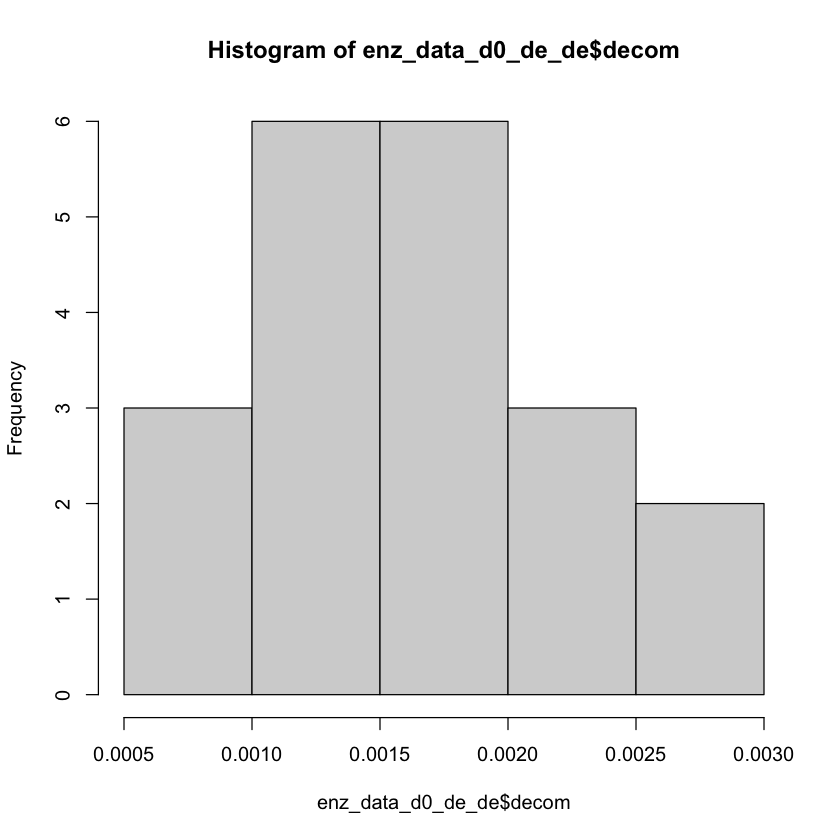

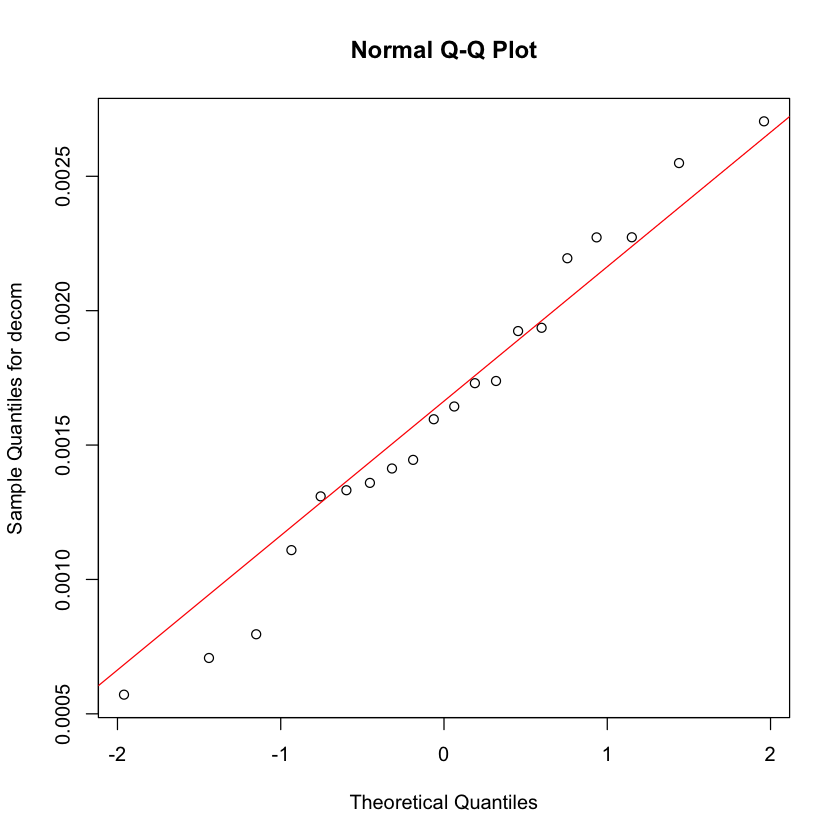

In [14]:
enz_data_d0_de_de = enz_data_d0[enz_data_d0['origin'] == 'desert' & enz_data_d0['site'] == 'desert',]
hist(enz_data_d0_de_de$decom)
qqnorm(enz_data_d0_de_de$decom,ylab="Sample Quantiles for decom")
qqline(enz_data_d0_de_de$decom,col="red")

# enz_data_d0_su_su = enz_data_d0[enz_data_d0['origin'] == 'subalpine' & enz_data_d0['site'] == 'subalpine',]
# hist(log(enz_data_d0_su_su$decom))
# qqnorm(log(enz_data_d0_su_su$decom),ylab="Sample Quantiles for decom")
# qqline(log(enz_data_d0_su_su$decom),col="red")

In [15]:
enz_fit_d0 <- aov(decom ~ origin + site + origin:site, data=enz_data_d0)
summary(enz_fit_d0)

             Df    Sum Sq   Mean Sq F value   Pr(>F)    
origin        4 3.630e-06 9.084e-07   5.663 0.000185 ***
site          4 2.510e-06 6.263e-07   3.904 0.003942 ** 
origin:site  16 7.300e-07 4.570e-08   0.285 0.997393    
Residuals   475 7.619e-05 1.604e-07                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [16]:
cat('Contribution by each factor:',summary(enz_fit_d0)[[1]]$'Sum Sq'/sum(summary(enz_fit_d0)[[1]]$'Sum Sq'))

Contribution by each factor: 0.04374423 0.03015943 0.008806626 0.9172897

In [39]:
TukeyHSD(enz_fit_d0,ordered=TRUE)

  Tukey multiple comparisons of means
    95% family-wise confidence level
    factor levels have been ordered

Fit: aov(formula = decom ~ origin + site + origin:site, data = enz_data_d0)

$origin
                            diff           lwr          upr     p adj
grassland-desert    1.974717e-04  4.237629e-05 0.0003525670 0.0048385
scrubland-desert    2.089357e-04  5.384037e-05 0.0003640311 0.0023269
subalpine-desert    2.191802e-04  6.408486e-05 0.0003742756 0.0011691
pineoak-desert      2.224008e-04  6.730544e-05 0.0003774962 0.0009355
scrubland-grassland 1.146408e-05 -1.436313e-04 0.0001665595 0.9996254
subalpine-grassland 2.170856e-05 -1.333868e-04 0.0001768039 0.9954165
pineoak-grassland   2.492915e-05 -1.301662e-04 0.0001800245 0.9922006
subalpine-scrubland 1.024448e-05 -1.448509e-04 0.0001653399 0.9997602
pineoak-scrubland   1.346507e-05 -1.416303e-04 0.0001685604 0.9992923
pineoak-subalpine   3.220584e-06 -1.518748e-04 0.0001583160 0.9999976

$site
                          

In [17]:
# last day of the last year
enz_data_d2 <- data_anova(enz_data,1+365*4 + 365*4 - 1)
head(enz_data_d2)

,origin,site,decom
,<chr>,<chr>,<dbl>
X0,desert,desert,0.0015693954
X1,desert,desert,0.0021875966
X2,desert,desert,0.0010842525
X3,desert,desert,0.0005521731
X4,desert,desert,0.0013245111
X5,desert,desert,0.0018966636


In [18]:
enz_fit_d2 <- aov(decom ~ origin + site + origin:site, data=enz_data_d2)
summary(enz_fit_d2)

             Df    Sum Sq   Mean Sq F value   Pr(>F)    
origin        4 1.100e-06 2.754e-07   1.511    0.198    
site          4 7.210e-06 1.802e-06   9.882 1.09e-07 ***
origin:site  16 4.600e-07 2.870e-08   0.157    1.000    
Residuals   475 8.659e-05 1.823e-07                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [19]:
cat('Contribution by each factor:',summary(enz_fit_d2)[[1]]$'Sum Sq'/sum(summary(enz_fit_d2)[[1]]$'Sum Sq'))

Contribution by each factor: 0.01155115 0.07556813 0.004811448 0.9080693

In [42]:
## drought tolerance
#create file list and read the decomposition data into a list
file_list <- list()
for (i in 1:25){
    site=c('desert','scrubland','grassland','pineoak','subalpine')
    name<-data.frame(origin=rep(site,times=1,each=5),site=rep(site,times=5,each=1))

    file_list[i] = paste(name$origin[i],"/","Drt_",name$origin[i],"_",name$site[i],'.csv',sep="")
}
drt_data <- lapply(file_list,function(path)read.csv(path,row.names=1))

In [43]:
# last day of the first year
drt_data_d1 <- data_anova(drt_data,1+365*4 + 365 - 1)
head(drt_data_d1)

,origin,site,decom
,<chr>,<chr>,<dbl>
X0,desert,desert,0.9641955
X1,desert,desert,0.8851461
X2,desert,desert,0.9636836
X3,desert,desert,0.9150863
X4,desert,desert,0.9106528
X5,desert,desert,0.9010322


In [44]:
drt_fit_d1 <- aov(decom ~ origin + site + origin:site, data=drt_data_d1)
summary(drt_fit_d1)

             Df Sum Sq Mean Sq F value Pr(>F)    
origin        4  7.224  1.8061   323.9 <2e-16 ***
site          4  5.636  1.4089   252.7 <2e-16 ***
origin:site  16  1.071  0.0669    12.0 <2e-16 ***
Residuals   475  2.649  0.0056                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [47]:
cat('Contribution by each factor:',summary(drt_fit_d1)[[1]]$'Sum Sq'/sum(summary(drt_fit_d1)[[1]]$'Sum Sq'))

Contribution by each factor: 0.4357417 0.3399117 0.06458667 0.15976

In [48]:
# last day of the last year
drt_data_d2 <- data_anova(drt_data,1+365*4 + 365*4 - 1)
head(drt_data_d2)

,origin,site,decom
,<chr>,<chr>,<dbl>
X0,desert,desert,0.9723694
X1,desert,desert,0.8845438
X2,desert,desert,0.9636903
X3,desert,desert,0.9141868
X4,desert,desert,0.9155219
X5,desert,desert,0.9099207


In [49]:
drt_fit_d2 <- aov(decom ~ origin + site + origin:site, data=drt_data_d2)
summary(drt_fit_d2)

             Df Sum Sq Mean Sq F value Pr(>F)    
origin        4  3.583  0.8957  159.99 <2e-16 ***
site          4 11.504  2.8759  513.68 <2e-16 ***
origin:site  16  1.672  0.1045   18.67 <2e-16 ***
Residuals   475  2.659  0.0056                   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

In [50]:
cat('Contribution by each factor:',summary(drt_fit_d2)[[1]]$'Sum Sq'/sum(summary(drt_fit_d2)[[1]]$'Sum Sq'))

Contribution by each factor: 0.1845083 0.5924159 0.08612304 0.1369528

#### 2.3 Multiple Linear Regression of decomposition against trait and environment

A multiple linear regression and model selection performed on data of different days.

---

**R implementation**: 

Interaction Effect in Multiple Regression: Essentials: http://www.sthda.com/english/articles/40-regression-analysis/164-interaction-effect-in-multiple-regression-essentials/

Interactions in multiple linear regression: https://medium.com/@dkatzman_3920/interactions-in-multiple-linear-regression-9f735b12826b

In [62]:
#create file list and read the climate data into a list
file_list <- list()
for (i in 1:5){
    site=c('desert','scrubland','grassland','pineoak','subalpine')
    #name<-data.frame(origin=rep(site,times=1,each=1),site=rep(site,times=1,each=1))
    name<-rep(site,times=1,each=1)

    #file_list[i] = paste(name$origin[i],"/v1/","Sub_",name$origin[i],"_",name$site[i],'.csv',sep="")
    file_list[i] = paste("../../../inputs/",name[i],'/','climate.csv',sep="")
}
#climate_data <- lapply(file_list,function(path)read.csv(path,row.names=1))

# annual mean
climate_data <- lapply(file_list,function(path)colMeans(read.csv(path,row.names=1)))

In [63]:
climate_data

[[1]]
     Temp       Psi 
26.268447 -5.304724 

[[2]]
    Temp      Psi 
17.38935 -3.63366 

[[3]]
     Temp       Psi 
18.869704 -2.343992 

[[4]]
     Temp       Psi 
11.277296 -1.185888 

[[5]]
     Temp       Psi 
10.912715 -1.487242

In [81]:
#define a function of obtaining data of any day
# data_climate <- function(climate_data,day){
    
#     climate_data_fr <- do.call("cbind.data.frame", climate_data)
#     data_climate <- climate_data_fr[as.character(day),]
#     #colnames(data_climate) = c('temp','psi')
    
#     rsp_climate<-rbind(data_climate[,c(1,2)],data_climate[,c(3,4)],
#                    data_climate[,c(5,6)],data_climate[,c(7,8)],
#                    data_climate[,c(9,10)])
    
#     #data_climate<-rsp_climate[rep(2, 20), ]
#     climate_data<-rsp_climate[rep(seq_len(nrow(rsp_climate)), each = 20), ]
#     #rsp_climate[rep(seq_len(nrow(rsp_climate)), each = 20), ]
#     rownames(climate_data) <- c()

#     climate_data
# }

### 
data_climate <- function(climate_data){
    
    climate_data_fr <- do.call("cbind.data.frame", climate_data)
    data_climate <- climate_data_fr[,]
    #colnames(data_climate) = c('temp','psi')
    
    rsp_climate<-rbind(data_climate[,1],data_climate[,2],
                   data_climate[,3],data_climate[,4],
                   data_climate[,5])
    
    #data_climate<-rsp_climate[rep(2, 20), ]
    climate_data<-rsp_climate[rep(seq_len(nrow(rsp_climate)), each = 20), ]
    #rsp_climate[rep(seq_len(nrow(rsp_climate)), each = 20), ]
    colnames(climate_data) <- c('Temp','Psi')

    climate_data
}

In [40]:
#create file list and read the source biomass data into a list
file_list <- list()
for (i in 1:25){
    site=c('desert','scrubland','grassland','pineoak','subalpine')
    name<-data.frame(origin=rep(site,times=1,each=5),site=rep(site,times=5,each=1))

    file_list[i] = paste(name$origin[i],"/","Mic_",name$origin[i],"_",name$site[i],'.csv',sep="")
}
mic_data <- lapply(file_list,function(path)read.csv(path,row.names=1))

In [41]:
res <- cor(data_sub_d1$decom, data_anova(mic_data,1+365*4 + 200)$decom, method = "pearson")
cat('R=',res)

ERROR: Error in is.data.frame(x): object 'data_sub_d1' not found


In [42]:
plot(data_sub_d1$decom, data_anova(mic_data,1+365*4 + 1)$decom)

ERROR: Error in plot(data_sub_d1$decom, data_anova(mic_data, 1 + 365 * 4 + 1)$decom): object 'data_sub_d1' not found


#### First year

- with local environment of the last day

- with local env of the max in a year

- with local env averged across the whole year

In [43]:
# environment of the last day 
data_climate_d1 <- data_climate(climate_data,200)

data_sub_d1 <- data_anova(sub_data,1+365*4 + 365 - 1)
data_sub_d1[,'decom'] <- data_sub_d1$decom/10000
# day 1
data_enz_d1 <- data_anova(enz_data,1+365*4 + 365 - 1) # last day
data_drt_d1 <- data_anova(drt_data,1+365*4 + 365 - 1) # last day

# concatenate the same day climate and decomposition and traits (last day of the 1st year)
# into one dataframe
all_data_d1 <- cbind(data_sub_d1,data_climate_d1, data_enz_d1$decom,data_drt_d1$decom)
names(all_data_d1)[6] <- 'Enz'
names(all_data_d1)[7] <- 'Drt'
head(all_data_d1)

,origin,site,decom,Temp,Psi,Enz,Drt
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X0,desert,desert,260.4377,38.51389,-8.498463,0.0016435153,0.9641955
X1,desert,desert,259.2960,38.51389,-8.498463,0.0021950307,0.8851461
X2,desert,desert,289.8874,38.51389,-8.498463,0.0011091144,0.9636836
X3,desert,desert,309.1437,38.51389,-8.498463,0.0005713315,0.9150863
X4,desert,desert,255.3615,38.51389,-8.498463,0.0013090709,0.9106528
X5,desert,desert,263.3692,38.51389,-8.498463,0.0019363400,0.9010322


In [44]:
# model 1 w/ only Temp & Psi
mod1_d1 <- lm(decom ~ Temp + Psi, data=all_data_d1)
summary(mod1_d1)


Call:
lm(formula = decom ~ Temp + Psi, data = all_data_d1)

Residuals:
    Min      1Q  Median      3Q     Max 
-102.35  -47.35  -10.13   38.60  197.59 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  246.053     54.191   4.540 7.05e-06 ***
Temp          -8.601      2.718  -3.165  0.00165 ** 
Psi          -38.334      5.914  -6.482 2.18e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 62.51 on 497 degrees of freedom
Multiple R-squared:  0.4409,	Adjusted R-squared:  0.4386 
F-statistic:   196 on 2 and 497 DF,  p-value: < 2.2e-16


In [45]:
AIC(mod1_d1)
BIC(mod1_d1)

[1] 5559.237

[1] 5576.096

In [46]:
mod2_d1 <- lm(decom ~ Temp + Psi + Enz, data=all_data_d1)
summary(mod2_d1)


Call:
lm(formula = decom ~ Temp + Psi + Enz, data = all_data_d1)

Residuals:
     Min       1Q   Median       3Q      Max 
-114.140  -35.540   -5.425   32.212  161.913 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    476.897     47.710   9.996  < 2e-16 ***
Temp           -11.555      2.271  -5.088 5.14e-07 ***
Psi            -42.775      4.932  -8.672  < 2e-16 ***
Enz         -86180.275   5795.531 -14.870  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 52.04 on 496 degrees of freedom
Multiple R-squared:  0.6133,	Adjusted R-squared:  0.6109 
F-statistic: 262.2 on 3 and 496 DF,  p-value: < 2.2e-16


In [47]:
AIC(mod2_d1)
BIC(mod2_d1)

[1] 5376.903

[1] 5397.976

In [48]:
# model 3 with Drt instead of Enz
mod3_d1 <- lm(decom ~ Temp + Psi + Drt, data=all_data_d1)
summary(mod3_d1)


Call:
lm(formula = decom ~ Temp + Psi + Drt, data = all_data_d1)

Residuals:
     Min       1Q   Median       3Q      Max 
-122.519  -41.116   -0.665   37.660  131.330 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   66.055     46.656   1.416   0.1575    
Temp          -5.629      2.269  -2.481   0.0134 *  
Psi          -23.125      5.023  -4.604 5.28e-06 ***
Drt          233.056     15.622  14.918  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 51.99 on 496 degrees of freedom
Multiple R-squared:  0.6141,	Adjusted R-squared:  0.6117 
F-statistic: 263.1 on 3 and 496 DF,  p-value: < 2.2e-16


In [49]:
AIC(mod3_d1)
BIC(mod3_d1)

[1] 5375.903

[1] 5396.976

In [50]:
# Model 4 plus drought trait
mod4_d1 <- lm(decom ~ Temp + Psi + Enz + Drt, data=all_data_d1)
summary(mod4_d1)


Call:
lm(formula = decom ~ Temp + Psi + Enz + Drt, data = all_data_d1)

Residuals:
     Min       1Q   Median       3Q      Max 
-108.501  -31.539   -2.246   30.778  109.074 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    285.438     43.912   6.500 1.96e-10 ***
Temp            -8.583      1.981  -4.334 1.78e-05 ***
Psi            -29.920      4.387  -6.820 2.66e-11 ***
Enz         -67172.126   5231.817 -12.839  < 2e-16 ***
Drt            181.972     14.117  12.891  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 45.07 on 495 degrees of freedom
Multiple R-squared:  0.7105,	Adjusted R-squared:  0.7081 
F-statistic: 303.7 on 4 and 495 DF,  p-value: < 2.2e-16


In [51]:
AIC(mod4_d1)
BIC(mod4_d1)

[1] 5234.18

[1] 5259.468

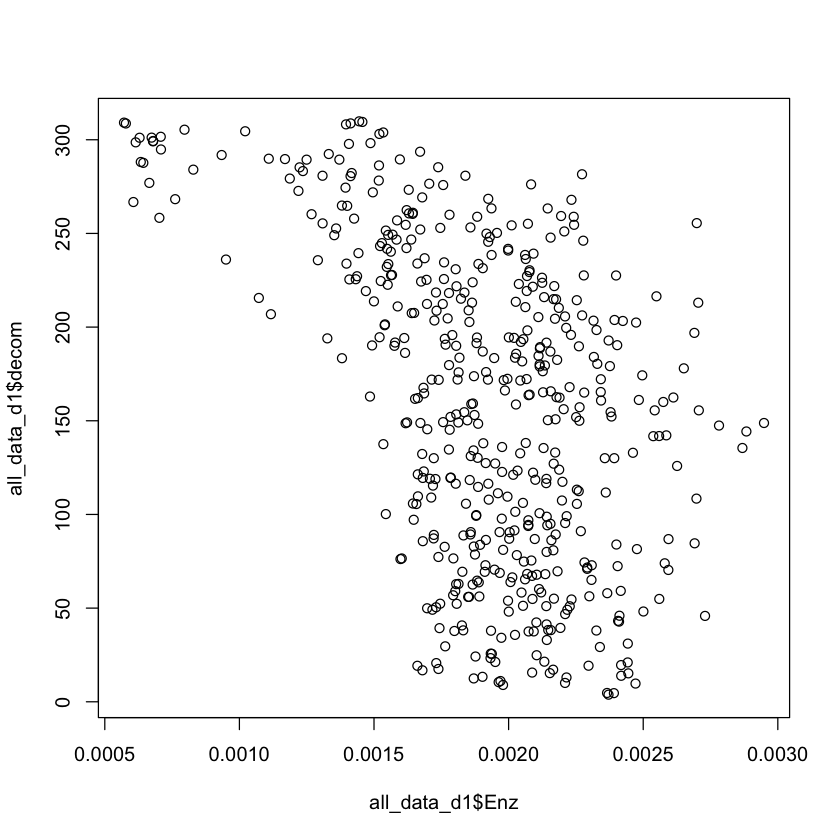

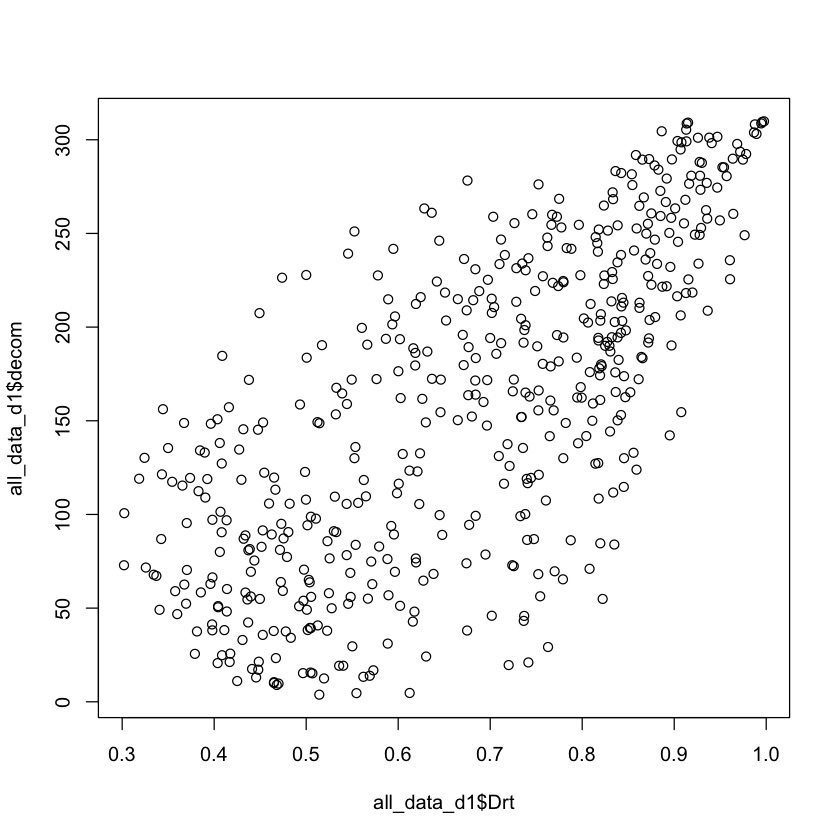

In [52]:
plot(all_data_d1$Enz, all_data_d1$decom)
plot(all_data_d1$Drt, all_data_d1$decom)

In [92]:
#### drought and enzyme traits of the first day 
data_climate_d2 <- data_climate(climate_data,200)

data_sub_d2 <- data_anova(sub_data,1+365*4 + 365 - 1)
data_sub_d2[,'decom'] <- data_sub_d2$decom/10000
data_enz_d2 <- data_anova(enz_data,1+365*4 + 1) # first day
data_drt_d2 <- data_anova(drt_data,1+365*4 + 1) # first day


# concatenate the same day climate and decomposition and traits (last day of the 1st year)
# into one dataframe
all_data_d2 <- cbind(data_sub_d2,data_climate_d2, data_enz_d2$decom,data_drt_d2$decom)
names(all_data_d2)[6] <- 'Enz'
names(all_data_d2)[7] <- 'Drt'

head(all_data_d2)

ERROR: Error in data_climate(climate_data, 200): unused argument (200)


In [54]:
# Model 1
mod1_d2 <- lm(decom ~ Temp + Psi, data=all_data_d2)
summary(mod1_d2)


Call:
lm(formula = decom ~ Temp + Psi, data = all_data_d2)

Residuals:
    Min      1Q  Median      3Q     Max 
-102.35  -47.35  -10.13   38.60  197.59 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  246.053     54.191   4.540 7.05e-06 ***
Temp          -8.601      2.718  -3.165  0.00165 ** 
Psi          -38.334      5.914  -6.482 2.18e-10 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 62.51 on 497 degrees of freedom
Multiple R-squared:  0.4409,	Adjusted R-squared:  0.4386 
F-statistic:   196 on 2 and 497 DF,  p-value: < 2.2e-16


In [55]:
AIC(mod1_d2)
BIC(mod1_d2)

[1] 5559.237

[1] 5576.096

In [56]:
# Model 2 plus enzyme trait
mod2_d2 <- lm(decom ~ Temp + Psi + Enz, data=all_data_d2)
summary(mod2_d2)


Call:
lm(formula = decom ~ Temp + Psi + Enz, data = all_data_d2)

Residuals:
     Min       1Q   Median       3Q      Max 
-109.539  -33.879   -4.429   30.096  150.715 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.429e+02  4.250e+01  10.421  < 2e-16 ***
Temp        -8.612e+00  2.067e+00  -4.166 3.66e-05 ***
Psi         -3.836e+01  4.499e+00  -8.527  < 2e-16 ***
Enz         -1.039e+05  5.458e+03 -19.045  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 47.56 on 496 degrees of freedom
Multiple R-squared:  0.677,	Adjusted R-squared:  0.6751 
F-statistic: 346.6 on 3 and 496 DF,  p-value: < 2.2e-16


In [57]:
AIC(mod2_d2)
BIC(mod2_d2)

[1] 5286.818

[1] 5307.891

In [60]:
# Model 3 with drt instead of enz
mod3_d2 <- lm(decom ~ Temp + Psi + Enz, data=all_data_d2)
summary(mod3_d2)


Call:
lm(formula = decom ~ Temp + Psi + Enz, data = all_data_d2)

Residuals:
     Min       1Q   Median       3Q      Max 
-109.539  -33.879   -4.429   30.096  150.715 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  4.429e+02  4.250e+01  10.421  < 2e-16 ***
Temp        -8.612e+00  2.067e+00  -4.166 3.66e-05 ***
Psi         -3.836e+01  4.499e+00  -8.527  < 2e-16 ***
Enz         -1.039e+05  5.458e+03 -19.045  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 47.56 on 496 degrees of freedom
Multiple R-squared:  0.677,	Adjusted R-squared:  0.6751 
F-statistic: 346.6 on 3 and 496 DF,  p-value: < 2.2e-16


In [61]:
AIC(mod3_d2)
BIC(mod3_d2)

[1] 5286.818

[1] 5307.891

In [62]:
# Model 3 plus drought trait
mod4_d2 <- lm(decom ~ Temp + Psi + Enz + Drt, data=all_data_d2)
summary(mod4_d2)


Call:
lm(formula = decom ~ Temp + Psi + Enz + Drt, data = all_data_d2)

Residuals:
    Min      1Q  Median      3Q     Max 
-99.331 -32.086  -2.737  30.344 119.052 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    340.789     38.802   8.783  < 2e-16 ***
Temp            -8.610      1.838  -4.686 3.61e-06 ***
Psi            -38.357      3.999  -9.592  < 2e-16 ***
Enz         -86330.857   5085.530 -16.976  < 2e-16 ***
Drt            108.772      9.436  11.528  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 42.27 on 495 degrees of freedom
Multiple R-squared:  0.7454,	Adjusted R-squared:  0.7433 
F-statistic: 362.3 on 4 and 495 DF,  p-value: < 2.2e-16


In [63]:
AIC(mod4_d2)
BIC(mod4_d2)

[1] 5169.92

[1] 5195.207

In [82]:
#################################
## with mean local temp and psi
################################

data_climate_d2m <- data_climate(climate_data)

data_sub_d2m <- data_anova(sub_data,1+365*4 + 365 - 1)
data_sub_d2m[,'decom'] <- data_sub_d2m$decom/10000
data_enz_d2m <- data_anova(enz_data,1+365*4 + 1) # first day
data_drt_d2m <- data_anova(drt_data,1+365*4 + 1) # first day


# concatenate the same day climate and decomposition and traits (last day of the 1st year)
# into one dataframe
all_data_d2m <- cbind(data_sub_d2m,data_climate_d2m, data_enz_d2m$decom,data_drt_d2m$decom)
names(all_data_d2m)[6] <- 'Enz'
names(all_data_d2m)[7] <- 'Drt'

head(all_data_d2m)

,origin,site,decom,Temp,Psi,Enz,Drt
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X0,desert,desert,260.4377,26.26845,-5.304724,0.001688039,0.9598001
X1,desert,desert,259.2960,26.26845,-5.304724,0.002173554,0.8839917
X2,desert,desert,289.8874,26.26845,-5.304724,0.001145072,0.9605490
X3,desert,desert,309.1437,26.26845,-5.304724,0.000590922,0.9160625
X4,desert,desert,255.3615,26.26845,-5.304724,0.001276322,0.9105744
X5,desert,desert,263.3692,26.26845,-5.304724,0.001928113,0.8970926


In [83]:
# Model 1 with only temp and psi
mod1_d2m <- lm(decom ~ Temp + Psi, data=all_data_d2m)
summary(mod1_d2m)


Call:
lm(formula = decom ~ Temp + Psi, data = all_data_d2m)

Residuals:
    Min      1Q  Median      3Q     Max 
-109.20  -47.55   -8.66   37.02  192.29 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   94.064     11.601   8.108 4.04e-15 ***
Temp          -4.880      1.377  -3.545  0.00043 ***
Psi          -52.522      5.123 -10.253  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 62.89 on 497 degrees of freedom
Multiple R-squared:  0.434,	Adjusted R-squared:  0.4317 
F-statistic: 190.5 on 2 and 497 DF,  p-value: < 2.2e-16


In [84]:
AIC(mod1_d2m)
BIC(mod1_d2m)

[1] 5565.381

[1] 5582.239

In [85]:
# Model 1 plus enzyme trait
mod2_d2m <- lm(decom ~ Temp + Psi + Enz, data=all_data_d2m)
summary(mod2_d2m)


Call:
lm(formula = decom ~ Temp + Psi + Enz, data = all_data_d2m)

Residuals:
     Min       1Q   Median       3Q      Max 
-107.033  -34.510   -3.968   33.328  145.421 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.907e+02  1.370e+01  21.230  < 2e-16 ***
Temp        -4.884e+00  1.052e+00  -4.642 4.42e-06 ***
Psi         -5.255e+01  3.915e+00 -13.423  < 2e-16 ***
Enz         -1.039e+05  5.516e+03 -18.843  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 48.06 on 496 degrees of freedom
Multiple R-squared:  0.6701,	Adjusted R-squared:  0.6681 
F-statistic: 335.8 on 3 and 496 DF,  p-value: < 2.2e-16


In [86]:
AIC(mod2_d2m)
BIC(mod2_d2m)

[1] 5297.439

[1] 5318.512

In [88]:
# Model 1 plus drought trait
mod3_d2m <- lm(decom ~ Temp + Psi + Drt, data=all_data_d2m)
summary(mod3_d2m)


Call:
lm(formula = decom ~ Temp + Psi + Drt, data = all_data_d2m)

Residuals:
     Min       1Q   Median       3Q      Max 
-136.842  -39.248   -1.602   38.189  138.234 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -5.150     12.234  -0.421    0.674    
Temp          -4.879      1.172  -4.162 3.72e-05 ***
Psi          -52.517      4.363 -12.037  < 2e-16 ***
Drt          156.880     11.406  13.754  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 53.57 on 496 degrees of freedom
Multiple R-squared:  0.5902,	Adjusted R-squared:  0.5878 
F-statistic: 238.2 on 3 and 496 DF,  p-value: < 2.2e-16


In [89]:
AIC(mod3_d2m)
BIC(mod3_d2m)

[1] 5405.831

[1] 5426.904

In [90]:
# Model 4 plus drought + enzyme trait
mod4_d2m <- lm(decom ~ Temp + Psi + Drt + Enz, data=all_data_d2m)
summary(mod4_d2m)


Call:
lm(formula = decom ~ Temp + Psi + Drt + Enz, data = all_data_d2m)

Residuals:
   Min     1Q Median     3Q    Max 
-96.83 -32.98  -1.05  30.25 117.45 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.886e+02  1.515e+01  12.449  < 2e-16 ***
Temp        -4.883e+00  9.376e-01  -5.208 2.81e-07 ***
Psi         -5.254e+01  3.489e+00 -15.058  < 2e-16 ***
Drt          1.088e+02  9.563e+00  11.374  < 2e-16 ***
Enz         -8.633e+04  5.154e+03 -16.748  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 42.84 on 495 degrees of freedom
Multiple R-squared:  0.7385,	Adjusted R-squared:  0.7363 
F-statistic: 349.4 on 4 and 495 DF,  p-value: < 2.2e-16


In [91]:
AIC(mod4_d2m)
BIC(mod4_d2m)

[1] 5183.352

[1] 5208.639

#### 4th year

In [64]:
# environment of the last day 
data_climate_d3 <- data_climate(climate_data,200)

data_sub_d3 <- data_anova(sub_data,1+365*7 + 365 - 1)
data_sub_d3[,'decom'] <- data_sub_d3$decom/10000
# day 1
data_enz_d3 <- data_anova(enz_data,1+365*7 + 365 - 1)
data_drt_d3 <- data_anova(drt_data,1+365*7 + 365 - 1)

# concatenate the same day climate and decomposition and traits (last day of the 1st year)
# into one dataframe
all_data_d3 <- cbind(data_sub_d3,data_climate_d3, data_enz_d3$decom,data_drt_d3$decom)
names(all_data_d3)[6] <- 'Enz'
names(all_data_d3)[7] <- 'Drt'
head(all_data_d3)

,origin,site,decom,Temp,Psi,Enz,Drt
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X0,desert,desert,269.9034,38.51389,-8.498463,0.0015693954,0.9723694
X1,desert,desert,261.5293,38.51389,-8.498463,0.0021875966,0.8845438
X2,desert,desert,290.3816,38.51389,-8.498463,0.0010842525,0.9636903
X3,desert,desert,310.0326,38.51389,-8.498463,0.0005521731,0.9141868
X4,desert,desert,257.3524,38.51389,-8.498463,0.0013245111,0.9155219
X5,desert,desert,272.3189,38.51389,-8.498463,0.0018966636,0.9099207


In [65]:
# Model 1 
mod1_d3 <- lm(decom ~ Temp + Psi, data=all_data_d3)
summary(mod1_d3)


Call:
lm(formula = decom ~ Temp + Psi, data = all_data_d3)

Residuals:
    Min      1Q  Median      3Q     Max 
-94.867 -38.559  -8.202  31.508 210.195 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  180.217     46.291   3.893 0.000112 ***
Temp          -6.814      2.321  -2.935 0.003488 ** 
Psi          -42.077      5.052  -8.329 7.97e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 53.4 on 497 degrees of freedom
Multiple R-squared:  0.6694,	Adjusted R-squared:  0.6681 
F-statistic: 503.2 on 2 and 497 DF,  p-value: < 2.2e-16


In [66]:
AIC(mod1_d3)
BIC(mod1_d3)

[1] 5401.673

[1] 5418.532

In [67]:
# Model 2 
mod2_d3 <- lm(decom ~ Temp + Psi + Enz, data=all_data_d3)
summary(mod2_d3)


Call:
lm(formula = decom ~ Temp + Psi + Enz, data = all_data_d3)

Residuals:
    Min      1Q  Median      3Q     Max 
-93.827 -34.732  -2.536  23.975 172.627 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    378.285     40.625   9.312  < 2e-16 ***
Temp            -9.535      1.935  -4.927 1.14e-06 ***
Psi            -45.143      4.198 -10.753  < 2e-16 ***
Enz         -70618.836   4703.714 -15.013  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 44.32 on 496 degrees of freedom
Multiple R-squared:  0.7727,	Adjusted R-squared:  0.7713 
F-statistic: 562.1 on 3 and 496 DF,  p-value: < 2.2e-16


In [68]:
AIC(mod2_d3)
BIC(mod2_d3)

[1] 5216.363

[1] 5237.436

In [71]:
# Model 3
mod3_d3 <- lm(decom ~ Temp + Psi + Drt, data=all_data_d3)
summary(mod3_d3)


Call:
lm(formula = decom ~ Temp + Psi + Drt, data = all_data_d3)

Residuals:
     Min       1Q   Median       3Q      Max 
-105.920  -37.282   -4.786   33.736  151.170 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   14.738     46.650   0.316    0.752    
Temp          -2.143      2.213  -0.968    0.333    
Psi          -23.712      5.104  -4.646 4.35e-06 ***
Drt          156.509     17.280   9.057  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 49.51 on 496 degrees of freedom
Multiple R-squared:  0.7163,	Adjusted R-squared:  0.7146 
F-statistic: 417.5 on 3 and 496 DF,  p-value: < 2.2e-16


In [72]:
AIC(mod3_d3)
BIC(mod3_d3)

[1] 5327.142

[1] 5348.215

In [73]:
# Model 3 
mod4_d3 <- lm(decom ~ Temp + Psi + Enz + Drt, data=all_data_d3)
summary(mod4_d3)


Call:
lm(formula = decom ~ Temp + Psi + Enz + Drt, data = all_data_d3)

Residuals:
    Min      1Q  Median      3Q     Max 
-94.347 -32.964  -2.782  27.851 130.873 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    242.224     43.141   5.615 3.29e-08 ***
Temp            -6.006      1.909  -3.146  0.00176 ** 
Psi            -32.096      4.397  -7.299 1.16e-12 ***
Enz         -62953.956   4609.175 -13.658  < 2e-16 ***
Drt            108.353     15.157   7.149 3.16e-12 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 42.24 on 495 degrees of freedom
Multiple R-squared:  0.794,	Adjusted R-squared:  0.7923 
F-statistic: 476.9 on 4 and 495 DF,  p-value: < 2.2e-16


In [74]:
AIC(mod4_d3)
BIC(mod4_d3)

[1] 5169.235

[1] 5194.522

In [93]:
########################
# mean environment of the whole year
########################

data_climate_d3m <- data_climate(climate_data)

data_sub_d3m <- data_anova(sub_data,1+365*7 + 365 - 1)
data_sub_d3m[,'decom'] <- data_sub_d3m$decom/10000
# day 1
data_enz_d3m <- data_anova(enz_data,1+365*7 + 365 - 1)
data_drt_d3m <- data_anova(drt_data,1+365*7 + 365 - 1)

# concatenate the same day climate and decomposition and traits (last day of the 1st year)
# into one dataframe
all_data_d3m <- cbind(data_sub_d3m,data_climate_d3m, data_enz_d3m$decom,data_drt_d3m$decom)
names(all_data_d3m)[6] <- 'Enz'
names(all_data_d3m)[7] <- 'Drt'
head(all_data_d3m)

,origin,site,decom,Temp,Psi,Enz,Drt
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X0,desert,desert,269.9034,26.26845,-5.304724,0.0015693954,0.9723694
X1,desert,desert,261.5293,26.26845,-5.304724,0.0021875966,0.8845438
X2,desert,desert,290.3816,26.26845,-5.304724,0.0010842525,0.9636903
X3,desert,desert,310.0326,26.26845,-5.304724,0.0005521731,0.9141868
X4,desert,desert,257.3524,26.26845,-5.304724,0.0013245111,0.9155219
X5,desert,desert,272.3189,26.26845,-5.304724,0.0018966636,0.9099207


In [94]:
# Model 1 
mod1_d3m <- lm(decom ~ Temp + Psi, data=all_data_d3m)
summary(mod1_d3m)


Call:
lm(formula = decom ~ Temp + Psi, data = all_data_d3m)

Residuals:
    Min      1Q  Median      3Q     Max 
-91.630 -40.373  -4.036  29.535 197.537 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   52.041      9.936   5.238 2.41e-07 ***
Temp          -4.239      1.179  -3.595 0.000357 ***
Psi          -64.098      4.387 -14.609  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 53.87 on 497 degrees of freedom
Multiple R-squared:  0.6636,	Adjusted R-squared:  0.6622 
F-statistic: 490.2 on 2 and 497 DF,  p-value: < 2.2e-16


In [95]:
AIC(mod1_d3m)
BIC(mod1_d3m)

[1] 5410.421

[1] 5427.28

In [96]:
# Model 2 
mod2_d3m <- lm(decom ~ Temp + Psi + Enz, data=all_data_d3m)
summary(mod2_d3m)


Call:
lm(formula = decom ~ Temp + Psi + Enz, data = all_data_d3m)

Residuals:
    Min      1Q  Median      3Q     Max 
-91.082 -33.588  -1.192  27.417 169.574 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.061e+02  1.340e+01  15.386  < 2e-16 ***
Temp        -5.391e+00  9.889e-01  -5.452 7.88e-08 ***
Psi         -6.302e+01  3.669e+00 -17.176  < 2e-16 ***
Enz         -7.008e+04  4.780e+03 -14.660  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 45.04 on 496 degrees of freedom
Multiple R-squared:  0.7653,	Adjusted R-squared:  0.7639 
F-statistic: 539.1 on 3 and 496 DF,  p-value: < 2.2e-16


In [97]:
AIC(mod2_d3m)
BIC(mod2_d3m)

[1] 5232.422

[1] 5253.495

In [98]:
# Model 3 
mod3_d3m <- lm(decom ~ Temp + Psi + Drt, data=all_data_d3m)
summary(mod3_d3m)


Call:
lm(formula = decom ~ Temp + Psi + Drt, data = all_data_d3m)

Residuals:
   Min     1Q Median     3Q    Max 
-96.18 -38.86  -3.81  35.28 140.97 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -23.098     12.076  -1.913  0.05636 .  
Temp          -3.128      1.091  -2.866  0.00433 ** 
Psi          -44.809      4.517  -9.920  < 2e-16 ***
Drt          160.413     16.839   9.526  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 49.57 on 496 degrees of freedom
Multiple R-squared:  0.7156,	Adjusted R-squared:  0.7139 
F-statistic:   416 on 3 and 496 DF,  p-value: < 2.2e-16


In [99]:
AIC(mod3_d3m)
BIC(mod3_d3m)

[1] 5328.406

[1] 5349.48

In [100]:
# Model 4 
mod4_d3m <- lm(decom ~ Temp + Psi + Enz + Drt, data=all_data_d3m)
summary(mod4_d3m)


Call:
lm(formula = decom ~ Temp + Psi + Enz + Drt, data = all_data_d3m)

Residuals:
    Min      1Q  Median      3Q     Max 
-93.596 -33.783  -0.116  27.741 121.948 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.334e+02  1.549e+01   8.615  < 2e-16 ***
Temp        -4.441e+00  9.379e-01  -4.735 2.87e-06 ***
Psi         -4.885e+01  3.873e+00 -12.614  < 2e-16 ***
Enz         -6.234e+04  4.599e+03 -13.556  < 2e-16 ***
Drt          1.188e+02  1.472e+01   8.075 5.19e-15 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 42.38 on 495 degrees of freedom
Multiple R-squared:  0.7926,	Adjusted R-squared:  0.7909 
F-statistic: 472.9 on 4 and 495 DF,  p-value: < 2.2e-16


In [101]:
AIC(mod4_d3m)
BIC(mod4_d3m)

[1] 5172.556

[1] 5197.844

## 3. Model validation

Validate the decomposition model derived from transplant data with the data before transplant 

In [139]:
sub_anova_origin <- data_anova(sub_data,1+365*3 + 365 - 1) # substrate
sub_anova_origin[,'decom'] <- sub_anova_origin$decom/10000
drt_anova_origin <- data_anova(drt_data,1+365*3) # drought trait
enz_anova_origin <- data_anova(enz_data,1+365*3) # enzyme trait

all_data_d0 <- cbind(sub_anova_origin,data_climate_d2, enz_anova_origin$decom,drt_anova_origin$decom)

names(all_data_d0)[6] <- 'Enz'
names(all_data_d0)[7] <- 'Drt'
head(all_data_d0)

,origin,site,decom,Temp,Psi,Enz,Drt
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
X0,desert,desert,255.7969,38.51389,-8.498463,0.0017441899,0.9538912
X1,desert,desert,259.8060,38.51389,-8.498463,0.0021854136,0.8841575
X2,desert,desert,288.0928,38.51389,-8.498463,0.0012227752,0.9524790
X3,desert,desert,307.3738,38.51389,-8.498463,0.0006593236,0.9180293
X4,desert,desert,255.9100,38.51389,-8.498463,0.0012906085,0.9050124
X5,desert,desert,256.6868,38.51389,-8.498463,0.0019116473,0.8900117


In [140]:
decomp_predic = -8.610*all_data_d0$Temp + (-38.357)*all_data_d0$Psi +
                (-86330.857)*all_data_d0$Enz + 108.772*all_data_d0$Drt  + 340.789

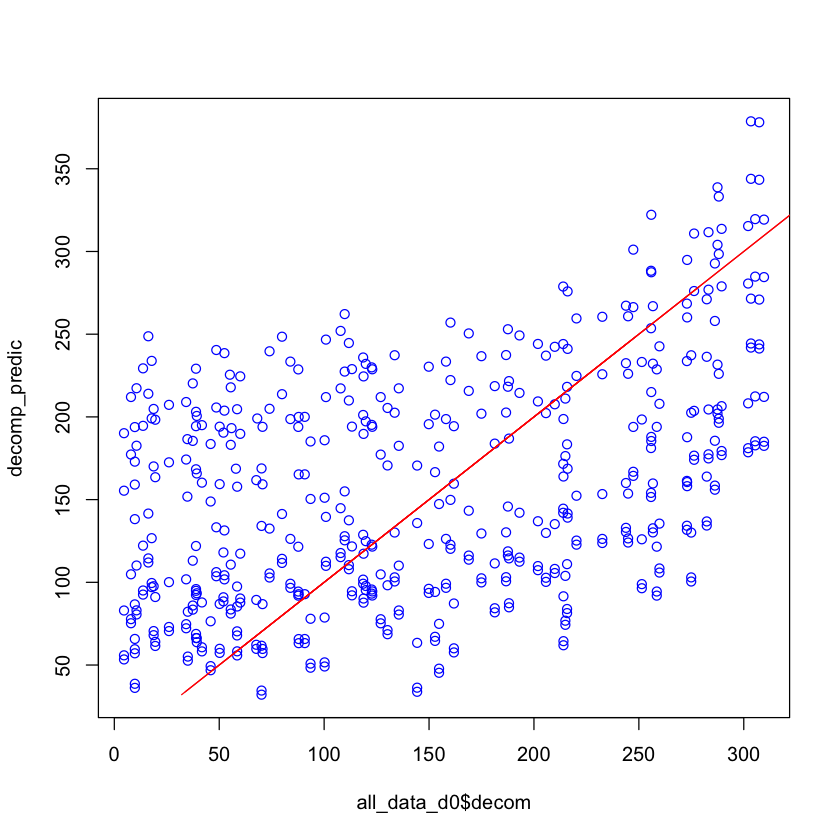

In [141]:
plot(all_data_d0$decom,decomp_predic,col='blue')
lines(decomp_predic, decomp_predic,col="red") 

In [56]:
to_python <- cbind(all_data_d0$decom,decomp_predic)
write.csv(to_python,'model_validation.csv')

In [142]:
res <- cor(all_data_d0$decom, decomp_predic, method = "pearson")
cat('R=',res)

R2= 0.4588212

In [143]:
RMSE = sqrt(mean((decomp_predic - all_data_d0$decom)^2))
cat('RMSE=',RMSE)

RMSE= 88.28066